In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import torch
print(torch.cuda.device_count())   # should be 1 now
print(torch.cuda.get_device_name(0))  # GPU 8 will appear as cuda:0

import torch

print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Number of visible GPUs: {torch.cuda.device_count()}")

for i in range(torch.cuda.device_count()):
    print(f"Device {i}: {torch.cuda.get_device_name(i)}")



1
NVIDIA L40S
CUDA available: True
Number of visible GPUs: 1
Device 0: NVIDIA L40S


In [2]:
# === Imports & runtime knobs ===================================================
import os
os.environ.setdefault("PYTORCH_CUDA_ALLOC_CONF", "expandable_segments:True")

import cv2
import numpy as np
import random
import torch
import gc
import pandas as pd
from tqdm import tqdm
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import json
import time
from datetime import datetime

# cuDNN stability (helps avoid CUDNN_STATUS_EXECUTION_FAILED on some GPUs)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.set_float32_matmul_precision("high")  # inference-only; avoids AMP surprises

# === Image preprocessing =======================================================
class ImagePreprocessor:
    def __init__(self, square_size=3052, target_size=(1024, 1024)):
        self.square_size = square_size
        self.target_size = target_size

    def analyze_image_color_distribution(self, image):
        """
        Analyze grayscale histogram on the original image.
        Pick mode in [21..234]; fallback sensibly; return ±20 absolute range.
        """
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image

        hist = cv2.calcHist([gray], [0], None, [256], [0, 256]).flatten()

        hist_for_peaks = hist.copy()
        hist_for_peaks[:21] = 0
        hist_for_peaks[235:] = 0

        if np.sum(hist_for_peaks) > 0:
            mode_value = int(np.argmax(hist_for_peaks))
        else:
            hist_fallback = hist.copy()
            hist_fallback[0] = 0
            hist_fallback[255] = 0
            mode_value = int(np.argmax(hist_fallback)) if np.sum(hist_fallback) > 0 else 128

        if mode_value <= 20 or mode_value >= 235:
            hist_copy = hist.copy()
            hist_copy[mode_value] = 0
            hist_copy[:21] = 0
            hist_copy[235:] = 0
            mode_value = int(np.argmax(hist_copy)) if np.sum(hist_copy) > 0 else 128

        min_noise_color = max(0, mode_value - 20)
        max_noise_color = min(255, mode_value + 20)
        return mode_value, (min_noise_color, max_noise_color), hist

    def pad_to_square_and_resize(self, image_path, analyze_colors=True):
        """
        Load image, run color analysis on original, pad to square with black,
        resize to 1024x1024.
        """
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Cannot load image: {image_path}")

        color_analysis = None
        if analyze_colors:
            mode_value, noise_range, hist = self.analyze_image_color_distribution(image)
            color_analysis = {'mode_value': mode_value, 'noise_range': noise_range, 'histogram': hist}

        h, w = image.shape[:2]
        max_dim = max(h, w, self.square_size)

        pad_h = max_dim - h
        pad_w = max_dim - w
        top = pad_h // 2
        bottom = pad_h - top
        left = pad_w // 2
        right = pad_w - left

        if len(image.shape) == 3:
            padded = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
        else:
            padded = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)

        resized = cv2.resize(padded, self.target_size, interpolation=cv2.INTER_LANCZOS4)
        return resized, color_analysis

# === Noise injection (no visualization) =======================================
class NoiseInjector:
    def __init__(self):
        pass

    def create_circle_mask(self, radius):
        size = 2 * radius + 1
        y, x = np.ogrid[:size, :size]
        center = radius
        return (x - center) ** 2 + (y - center) ** 2 <= radius ** 2

    def add_adaptive_circle_noise(self, image, color_analysis, radius=1, num_circles=1):
        """
        Draw circular dots in center 70% region; intensity sampled from mode ±20 absolute.
        """
        if color_analysis is None:
            return self.add_circle_noise(image, radius, num_circles)

        image_with_noise = image.copy()
        h, w = image.shape[:2]

        margin_x, margin_y = int(0.15 * w), int(0.15 * h)
        x_min, y_min = margin_x + radius, margin_y + radius
        x_max, y_max = w - margin_x - radius - 1, h - margin_y - radius - 1

        min_color, max_color = color_analysis['noise_range']
        mode_value = color_analysis['mode_value']
        if (max_color - min_color) < 5:
            min_color = max(0, mode_value - 20)
            max_color = min(255, mode_value + 20)

        circle_mask = self.create_circle_mask(radius)

        for _ in range(num_circles):
            x = random.randint(x_min, x_max)
            y = random.randint(y_min, y_max)
            noise_color = random.randint(min_color, max_color)

            y_start, y_end = max(0, y - radius), min(h, y + radius + 1)
            x_start, x_end = max(0, x - radius), min(w, x + radius + 1)

            region_h, region_w = y_end - y_start, x_end - x_start
            mask_y_start = max(0, radius - (y - y_start))
            mask_x_start = max(0, radius - (x - x_start))
            current_mask = circle_mask[mask_y_start:mask_y_start + region_h, mask_x_start:mask_x_start + region_w]

            # Works for both grayscale and 3-channel (sets all channels same intensity)
            image_with_noise[y_start:y_end, x_start:x_end][current_mask] = noise_color

        return image_with_noise

    # Backward-compat shim (old code called ..._with_marker)
    def add_adaptive_circle_noise_with_marker(self, image, color_analysis, radius=1, num_circles=1, add_boundary=False):
        return self.add_adaptive_circle_noise(image, color_analysis, radius=radius, num_circles=num_circles)

    def add_circle_noise(self, image, radius=1, num_circles=1):
        image_with_noise = image.copy()
        h, w = image.shape[:2]
        margin_x, margin_y = int(0.15 * w), int(0.15 * h)
        x_min, y_min = margin_x + radius, margin_y + radius
        x_max, y_max = w - margin_x - radius - 1, h - margin_y - radius - 1
        circle_mask = self.create_circle_mask(radius)

        for _ in range(num_circles):
            x = random.randint(x_min, x_max)
            y = random.randint(y_min, y_max)

            y_start, y_end = max(0, y - radius), min(h, y + radius + 1)
            x_start, x_end = max(0, x - radius), min(w, x + radius + 1)

            region_h, region_w = y_end - y_start, x_end - x_start
            mask_y_start = max(0, radius - (y - y_start))
            mask_x_start = max(0, radius - (x - x_start))
            current_mask = circle_mask[mask_y_start:mask_y_start + region_h, mask_x_start:mask_x_start + region_w]

            image_with_noise[y_start:y_end, x_start:x_end][current_mask] = 255
        return image_with_noise

# === Embedding extraction (robust forward) ====================================
class EmbeddingExtractor:
    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        self.load_raddino_model()

        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        self.load_dinov3_model()

    def load_raddino_model(self):
        try:
            print("Loading RadDiNo model...")
            self.raddino_processor = AutoImageProcessor.from_pretrained("microsoft/rad-dino")
            self.raddino_model = AutoModel.from_pretrained("microsoft/rad-dino").to(self.device)
            self.raddino_model.eval()
            print("RadDiNo model loaded successfully")
        except Exception as e:
            print(f"Error loading RadDiNo model: {e}")
            self.raddino_model = None
            self.raddino_processor = None

    def load_dinov3_model(self):
        try:
            print("Loading DINOv3 model...")
            self.dinov3_processor = AutoImageProcessor.from_pretrained("facebook/dinov3-vit7b16-pretrain-lvd1689m")
            self.dinov3_model = AutoModel.from_pretrained("facebook/dinov3-vit7b16-pretrain-lvd1689m").to(self.device)
            self.dinov3_model.eval()
            print("DINOv3 model loaded successfully")
        except Exception as e:
            print(f"Error loading DINOv3 model: {e}")
            self.dinov3_model = None
            self.dinov3_processor = None

    def _to_pil(self, image):
        if image.ndim == 3:
            return Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        else:
            return Image.fromarray(image).convert("RGB")

    def _safe_forward(self, model, processor, pil_list, device):
        """
        Try GPU+cuDNN; on cuDNN failure retry with cuDNN disabled; then CPU fallback (batch only).
        """
        def _run(_device, disable_cudnn=False):
            prev = torch.backends.cudnn.enabled
            if disable_cudnn:
                torch.backends.cudnn.enabled = False
            try:
                with torch.no_grad():
                    inputs = processor(pil_list, return_tensors="pt").to(_device)
                    outputs = model(**inputs)
                return outputs
            finally:
                if disable_cudnn:
                    torch.backends.cudnn.enabled = prev

        # Normal path
        try:
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            return _run(device, disable_cudnn=False)
        except RuntimeError as e:
            if "CUDNN_STATUS_EXECUTION_FAILED" not in str(e):
                raise
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            # Retry on GPU with cuDNN disabled
            try:
                return _run(device, disable_cudnn=True)
            except RuntimeError:
                # CPU fallback for this batch
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                cpu_device = torch.device("cpu")
                model_cpu = model.to(cpu_device)
                try:
                    return _run(cpu_device, disable_cudnn=True)
                finally:
                    model_cpu.to(device)

    def extract_raddino_batch(self, images):
        if self.raddino_model is None:
            return None
        pil_list = [self._to_pil(im) for im in images]
        outputs = self._safe_forward(self.raddino_model, self.raddino_processor, pil_list, self.device)
        if hasattr(outputs, "pooler_output") and outputs.pooler_output is not None:
            embs = outputs.pooler_output
        else:
            embs = outputs.last_hidden_state.mean(dim=1)
        return embs.detach().cpu().numpy()

    def extract_dinov3_batch(self, images):
        if self.dinov3_model is None:
            return None
        pil_list = [self._to_pil(im) for im in images]
        outputs = self._safe_forward(self.dinov3_model, self.dinov3_processor, pil_list, self.device)
        if hasattr(outputs, "pooler_output") and outputs.pooler_output is not None:
            embs = outputs.pooler_output
        else:
            embs = outputs.last_hidden_state.mean(dim=1)
        return embs.detach().cpu().numpy()

# === Progress tracking =========================================================
class ProgressTracker:
    def __init__(self, output_dir):
        self.output_dir = output_dir
        self.progress_file = os.path.join(output_dir, "progress.json")
        self.load_progress()

    def load_progress(self):
        if os.path.exists(self.progress_file):
            with open(self.progress_file, 'r') as f:
                self.progress = json.load(f)
        else:
            self.progress = {"completed_tasks": [], "current_task": None, "last_updated": None}

    def save_progress(self):
        self.progress["last_updated"] = datetime.now().isoformat()
        os.makedirs(self.output_dir, exist_ok=True)
        with open(self.progress_file, 'w') as f:
            json.dump(self.progress, f, indent=2)

    def is_task_completed(self, task_id):
        return task_id in self.progress["completed_tasks"]

    def mark_task_completed(self, task_id):
        if task_id not in self.progress["completed_tasks"]:
            self.progress["completed_tasks"].append(task_id)
        self.save_progress()

    def set_current_task(self, task_id):
        self.progress["current_task"] = task_id
        self.save_progress()

# === Full pipeline =============================================================
class ImagePipeline:
    """
    Pipeline: load CSVs -> pad/resize -> (optional) adaptive circle noise using mode ±20 ->
    extract embeddings (RadDiNO + DINOv3) -> save Parquet.
    """
    def __init__(self, root_path):
        self.root_path = root_path
        self.preprocessor = ImagePreprocessor()
        self.noise_injector = NoiseInjector()
        self.embedding_extractor = EmbeddingExtractor()

    def load_datasets(self, train_csv_path, test_csv_path):
        print("Loading datasets...")
        self.train_df = pd.read_csv(train_csv_path)
        self.test_df = pd.read_csv(test_csv_path)

        print(f"Train dataset shape: {self.train_df.shape}")
        print(f"Test dataset shape: {self.test_df.shape}")

        required_cols = ['ImagePath', 'noise']
        for df_name, df in [('train', self.train_df), ('test', self.test_df)]:
            missing_cols = [col for col in required_cols if col not in df.columns]
            if missing_cols:
                raise ValueError(f"Missing columns in {df_name} dataset: {missing_cols}")
        return self.train_df, self.test_df

    def process_single_image(self, image_path, add_noise=False, radius=1):
        full_image_path = image_path if os.path.isabs(image_path) else os.path.join(self.root_path, image_path)
        if not os.path.exists(full_image_path):
            raise FileNotFoundError(f"Image not found: {full_image_path}")

        processed_image, color_analysis = self.preprocessor.pad_to_square_and_resize(
            full_image_path, analyze_colors=True
        )

        if add_noise:
            # Use adaptive circle noise (no visualization)
            processed_image = self.noise_injector.add_adaptive_circle_noise(
                processed_image, color_analysis, radius=radius, num_circles=1
            )

        return processed_image

    def extract_embeddings_for_dataset_batched(
        self, df, dataset_name, radius, batch_size=32,
        save_intermediate=True, intermediate_save_frequency=100,
        resume_from_intermediate=True
    ):
        print(f"\nExtracting embeddings for {dataset_name} (radius={radius}) in batches of {batch_size}...")
        
        # Set up intermediate file path
        if save_intermediate:
            intermediate_dir = os.path.join(os.path.dirname(self.output_dir), "intermediate_saves")
            os.makedirs(intermediate_dir, exist_ok=True)
            intermediate_path = os.path.join(intermediate_dir, f"{dataset_name}_r{radius}_intermediate.parquet")
        
        # Check if we should resume from intermediate file
        if resume_from_intermediate and save_intermediate and os.path.exists(intermediate_path):
            print(f"Found intermediate file: {intermediate_path}")
            try:
                result_df = pd.read_parquet(intermediate_path)
                print(f"Loaded intermediate results with {len(result_df)} rows")
                
                # Verify the intermediate file has the expected structure
                rcol = f'raddino_embedding_r{radius}'
                dcol = f'dinov3_embedding_r{radius}'
                
                if rcol not in result_df.columns or dcol not in result_df.columns:
                    print("Intermediate file missing embedding columns, starting fresh...")
                    result_df = df.copy()
                    result_df[rcol] = None
                    result_df[dcol] = None
                    start_batch = 0
                else:
                    # Find where to resume - look for first row with None embeddings
                    processed_mask = (result_df[rcol].notna()) | (result_df[dcol].notna())
                    num_processed = processed_mask.sum()
                    
                    if num_processed == len(result_df):
                        print("All embeddings already extracted!")
                        return result_df
                    
                    # Calculate which batch to start from
                    start_batch = (num_processed // batch_size)
                    print(f"Resuming from batch {start_batch + 1} (processed {num_processed}/{len(result_df)} images)")
                    
            except Exception as e:
                print(f"Error loading intermediate file: {e}")
                print("Starting fresh...")
                result_df = df.copy()
                rcol = f'raddino_embedding_r{radius}'
                dcol = f'dinov3_embedding_r{radius}'
                result_df[rcol] = None
                result_df[dcol] = None
                start_batch = 0
        else:
            # Start fresh
            result_df = df.copy()
            rcol = f'raddino_embedding_r{radius}'
            dcol = f'dinov3_embedding_r{radius}'
            result_df[rcol] = None
            result_df[dcol] = None
            start_batch = 0

        idxs = result_df.index.tolist()
        total_batches = len(range(0, len(idxs), batch_size))
        
        # Skip already processed batches
        batch_count = start_batch
        start_idx = start_batch * batch_size
        
        for start in tqdm(range(start_idx, len(idxs), batch_size), 
                         desc=f"Processing {dataset_name}", 
                         initial=start_batch, total=total_batches):
            batch_start_time = time.time()
            end = min(start + batch_size, len(idxs))
            batch_idx = idxs[start:end]

            # Check if this batch is already processed (additional safety check)
            batch_processed = True
            for i in batch_idx:
                if pd.isna(result_df.at[i, rcol]) and pd.isna(result_df.at[i, dcol]):
                    batch_processed = False
                    break
            
            if batch_processed:
                print(f"Batch {batch_count + 1} already processed, skipping...")
                batch_count += 1
                continue

            # Load & process images
            load_start_time = time.time()
            imgs = []
            for i in batch_idx:
                row = result_df.loc[i]
                try:
                    add_noise = (row['noise'] == 1)
                    im = self.process_single_image(row['ImagePath'], add_noise=add_noise, radius=radius)
                except Exception as e:
                    print(f"Error processing {row['ImagePath']}: {e}")
                    im = None
                imgs.append(im)
            load_time = time.time() - load_start_time

            valid_mask = [im is not None for im in imgs]
            valid_imgs = [im for im, ok in zip(imgs, valid_mask) if ok]
            if len(valid_imgs) == 0:
                for i, ok in zip(batch_idx, valid_mask):
                    if not ok:
                        result_df.at[i, rcol] = None
                        result_df.at[i, dcol] = None
                batch_count += 1
                continue

            # Extract embeddings (use safety pre-sync)
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                torch.cuda.synchronize()

            embed_start_time = time.time()
            r_embs = self.embedding_extractor.extract_raddino_batch(valid_imgs)
            d_embs = self.embedding_extractor.extract_dinov3_batch(valid_imgs)
            embed_time = time.time() - embed_start_time

            # Store back
            store_start_time = time.time()
            valid_iter = iter(range(len(valid_imgs)))
            for i, ok in zip(batch_idx, valid_mask):
                if ok:
                    j = next(valid_iter)
                    result_df.at[i, rcol] = r_embs[j].tolist() if (r_embs is not None and len(r_embs) > j) else None
                    result_df.at[i, dcol] = d_embs[j].tolist() if (d_embs is not None and len(d_embs) > j) else None
                else:
                    result_df.at[i, rcol] = None
                    result_df.at[i, dcol] = None
            store_time = time.time() - store_start_time

            # Cleanup between batches
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()

            batch_count += 1
            batch_total_time = time.time() - batch_start_time

            # Intermediate saves
            if save_intermediate and (batch_count % intermediate_save_frequency == 0 or batch_count == total_batches):
                result_df.to_parquet(intermediate_path, index=False)
                print(f"Saved intermediate results to {intermediate_path}")

            if batch_count % 10 == 0 or batch_count == total_batches:
                print(f"\nBatch {batch_count}/{total_batches}: "
                      f"Load={load_time:.2f}s, Embed={embed_time:.2f}s, Store={store_time:.2f}s, "
                      f"Total={batch_total_time:.2f}s, Images/sec={len(valid_imgs)/batch_total_time:.2f}")
                if batch_count < total_batches:
                    avg_batch_time = batch_total_time
                    remaining_batches = total_batches - batch_count
                    est_min = remaining_batches * avg_batch_time / 60
                    print(f"Estimated remaining time: {est_min:.1f} minutes")

        return result_df

    def save_parquet_files(self, df, dataset_name, radius, output_dir="output"):
        os.makedirs(output_dir, exist_ok=True)

        base_cols = [c for c in ['AccessionNumber_anon', 'ImagePath', 'ViewPosition', 'CLAHE', 'Cardiomegaly', 'noise'] if c in df.columns]

        r_df = df[base_cols + [f'raddino_embedding_r{radius}']].copy()
        d_df = df[base_cols + [f'dinov3_embedding_r{radius}']].copy()

        r_path = f"{output_dir}/raddino-{dataset_name}-r{radius}.parquet"
        d_path = f"{output_dir}/dinov3-{dataset_name}-r{radius}.parquet"

        r_df.to_parquet(r_path, index=False)
        d_df.to_parquet(d_path, index=False)

        print(f"Saved: {r_path}")
        print(f"Saved: {d_path}")
        return r_path, d_path

    def run_single_radius(self, train_csv_path, test_csv_path, radius, output_dir="output", batch_size=32):
        print("=" * 60)
        print(f"PROCESSING CIRCLE RADIUS: {radius} (using mode ±20 color range)")
        print("=" * 60)

        self.output_dir = output_dir
        tracker = ProgressTracker(output_dir)

        train_df, test_df = self.load_datasets(train_csv_path, test_csv_path)

        train_task = f"train_r{radius}"
        test_task  = f"test_r{radius}"

        # Train
        if not tracker.is_task_completed(train_task):
            print(f"\nProcessing train dataset for radius {radius}...")
            tracker.set_current_task(train_task)
            train_result = self.extract_embeddings_for_dataset_batched(
                train_df, "train", radius, batch_size=batch_size,
                save_intermediate=True, intermediate_save_frequency=50
            )
            self.save_parquet_files(train_result, "train", radius, output_dir)
            tracker.mark_task_completed(train_task)
            del train_result
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        else:
            print(f"Train dataset for radius {radius} already completed. Skipping...")

        # Test
        if not tracker.is_task_completed(test_task):
            print(f"\nProcessing test dataset for radius {radius}...")
            tracker.set_current_task(test_task)
            test_result = self.extract_embeddings_for_dataset_batched(
                test_df, "test", radius, batch_size=batch_size,
                save_intermediate=True, intermediate_save_frequency=50
            )
            self.save_parquet_files(test_result, "test", radius, output_dir)
            tracker.mark_task_completed(test_task)
            del test_result
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        else:
            print(f"Test dataset for radius {radius} already completed. Skipping...")

        print(f"\nCompleted processing for radius {radius}")
        return True

    def run_complete_pipeline(self, train_csv_path, test_csv_path, radii=[1, 2], output_dir="output", batch_size=32):
        print(f"Starting complete pipeline for radii: {radii}")
        print("Using RadDiNo and DINOv3 models for medical imaging")
        print("Noise colors selected from mode ±20 range")
        for radius in radii:
            try:
                self.run_single_radius(train_csv_path, test_csv_path, radius, output_dir, batch_size)
                print(f"Successfully completed radius {radius}")
            except Exception as e:
                print(f"Error processing radius {radius}: {e}")
                continue
        print(f"\nComplete pipeline finished for all radii: {radii}")



/mnt/NAS3/homes/rmuthy2/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
if __name__ == "__main__":
    # Optionally pin a GPU:
    # os.environ["CUDA_VISIBLE_DEVICES"] = "0"

    pipeline = ImagePipeline(root_path="/home/rmuthy2/central_data/datasets/internal/EmoryCXRv2/ORIGINAL_PNG")
    pipeline.run_single_radius(
        train_csv_path="/home/rmuthy2/Circle/train_dataset.csv",
        test_csv_path="/home/rmuthy2/Circle/test_dataset.csv",
        radius=1,
        output_dir="/home/rmuthy2/Circle/EmbeddingsOut",
        batch_size=12  # lower if you still hit memory hiccups
    )

Using device: cuda
Loading RadDiNo model...


Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 11650.84it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


RadDiNo model loaded successfully
Loading DINOv3 model...


Loading checkpoint shards: 100%|██████████| 6/6 [00:00<00:00, 10.21it/s]


DINOv3 model loaded successfully
PROCESSING CIRCLE RADIUS: 1 (using mode ±20 color range)
Loading datasets...
Train dataset shape: (109824, 6)
Test dataset shape: (27456, 6)

Processing train dataset for radius 1...

Extracting embeddings for train (radius=1) in batches of 12...
Found intermediate file: /home/rmuthy2/Circle/intermediate_saves/train_r1_intermediate.parquet
Loaded intermediate results with 109824 rows
Resuming from batch 8351 (processed 100200/109824 images)


Processing train:  91%|█████████▏| 8360/9152 [00:26<33:52,  2.57s/it]


Batch 8360/9152: Load=1.61s, Embed=0.77s, Store=0.00s, Total=2.52s, Images/sec=4.76
Estimated remaining time: 33.3 minutes


Processing train:  91%|█████████▏| 8370/9152 [00:52<33:31,  2.57s/it]


Batch 8370/9152: Load=1.52s, Embed=0.78s, Store=0.00s, Total=2.46s, Images/sec=4.89
Estimated remaining time: 32.0 minutes


Processing train:  92%|█████████▏| 8380/9152 [01:18<33:22,  2.59s/it]


Batch 8380/9152: Load=1.63s, Embed=0.79s, Store=0.00s, Total=2.61s, Images/sec=4.59
Estimated remaining time: 33.6 minutes


Processing train:  92%|█████████▏| 8390/9152 [01:44<33:40,  2.65s/it]


Batch 8390/9152: Load=1.66s, Embed=0.78s, Store=0.00s, Total=2.59s, Images/sec=4.63
Estimated remaining time: 32.9 minutes


Processing train:  92%|█████████▏| 8400/9152 [02:32<1:50:31,  8.82s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/train_r1_intermediate.parquet

Batch 8400/9152: Load=1.71s, Embed=0.80s, Store=0.00s, Total=2.68s, Images/sec=4.48
Estimated remaining time: 33.6 minutes


Processing train:  92%|█████████▏| 8410/9152 [02:58<34:27,  2.79s/it]  


Batch 8410/9152: Load=1.65s, Embed=0.79s, Store=0.00s, Total=2.62s, Images/sec=4.58
Estimated remaining time: 32.4 minutes


Processing train:  92%|█████████▏| 8420/9152 [03:25<33:34,  2.75s/it]


Batch 8420/9152: Load=1.81s, Embed=0.80s, Store=0.00s, Total=2.77s, Images/sec=4.33
Estimated remaining time: 33.8 minutes


Processing train:  92%|█████████▏| 8430/9152 [03:52<32:12,  2.68s/it]


Batch 8430/9152: Load=1.69s, Embed=0.79s, Store=0.00s, Total=2.65s, Images/sec=4.52
Estimated remaining time: 31.9 minutes


Processing train:  92%|█████████▏| 8440/9152 [04:19<31:42,  2.67s/it]


Batch 8440/9152: Load=1.71s, Embed=0.79s, Store=0.00s, Total=2.67s, Images/sec=4.50
Estimated remaining time: 31.6 minutes


Processing train:  92%|█████████▏| 8450/9152 [05:07<1:45:39,  9.03s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/train_r1_intermediate.parquet

Batch 8450/9152: Load=1.60s, Embed=0.81s, Store=0.00s, Total=2.58s, Images/sec=4.66
Estimated remaining time: 30.1 minutes


Processing train:  92%|█████████▏| 8460/9152 [05:34<32:20,  2.80s/it]  


Batch 8460/9152: Load=1.56s, Embed=0.80s, Store=0.00s, Total=2.53s, Images/sec=4.75
Estimated remaining time: 29.1 minutes


Processing train:  93%|█████████▎| 8470/9152 [06:01<31:12,  2.75s/it]


Batch 8470/9152: Load=1.79s, Embed=0.81s, Store=0.00s, Total=2.77s, Images/sec=4.33
Estimated remaining time: 31.5 minutes


Processing train:  93%|█████████▎| 8480/9152 [06:28<30:07,  2.69s/it]


Batch 8480/9152: Load=1.65s, Embed=0.81s, Store=0.00s, Total=2.63s, Images/sec=4.57
Estimated remaining time: 29.4 minutes


Processing train:  93%|█████████▎| 8490/9152 [06:55<30:18,  2.75s/it]


Batch 8490/9152: Load=1.79s, Embed=0.85s, Store=0.00s, Total=2.81s, Images/sec=4.26
Estimated remaining time: 31.0 minutes


Processing train:  93%|█████████▎| 8500/9152 [07:43<1:38:53,  9.10s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/train_r1_intermediate.parquet

Batch 8500/9152: Load=1.72s, Embed=0.79s, Store=0.00s, Total=2.68s, Images/sec=4.49
Estimated remaining time: 29.1 minutes


Processing train:  93%|█████████▎| 8510/9152 [08:10<30:20,  2.84s/it]  


Batch 8510/9152: Load=1.62s, Embed=0.81s, Store=0.00s, Total=2.61s, Images/sec=4.61
Estimated remaining time: 27.9 minutes


Processing train:  93%|█████████▎| 8520/9152 [08:37<28:31,  2.71s/it]


Batch 8520/9152: Load=1.65s, Embed=0.80s, Store=0.00s, Total=2.63s, Images/sec=4.57
Estimated remaining time: 27.7 minutes


Processing train:  93%|█████████▎| 8530/9152 [09:10<31:02,  3.00s/it]


Batch 8530/9152: Load=1.64s, Embed=0.78s, Store=0.00s, Total=2.61s, Images/sec=4.60
Estimated remaining time: 27.0 minutes


Processing train:  93%|█████████▎| 8540/9152 [09:35<26:27,  2.59s/it]


Batch 8540/9152: Load=1.63s, Embed=0.76s, Store=0.00s, Total=2.64s, Images/sec=4.55
Estimated remaining time: 26.9 minutes


Processing train:  93%|█████████▎| 8550/9152 [10:23<1:30:55,  9.06s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/train_r1_intermediate.parquet

Batch 8550/9152: Load=1.60s, Embed=0.82s, Store=0.00s, Total=2.63s, Images/sec=4.57
Estimated remaining time: 26.4 minutes


Processing train:  94%|█████████▎| 8560/9152 [10:49<27:12,  2.76s/it]  


Batch 8560/9152: Load=1.58s, Embed=0.78s, Store=0.00s, Total=2.55s, Images/sec=4.71
Estimated remaining time: 25.2 minutes


Processing train:  94%|█████████▎| 8570/9152 [11:14<24:57,  2.57s/it]


Batch 8570/9152: Load=1.60s, Embed=0.78s, Store=0.00s, Total=2.56s, Images/sec=4.68
Estimated remaining time: 24.9 minutes


Processing train:  94%|█████████▍| 8580/9152 [11:46<34:49,  3.65s/it]


Batch 8580/9152: Load=2.12s, Embed=1.37s, Store=0.00s, Total=4.02s, Images/sec=2.99
Estimated remaining time: 38.3 minutes


Processing train:  94%|█████████▍| 8590/9152 [12:13<24:49,  2.65s/it]


Batch 8590/9152: Load=1.64s, Embed=0.78s, Store=0.00s, Total=2.63s, Images/sec=4.56
Estimated remaining time: 24.7 minutes


Processing train:  94%|█████████▍| 8600/9152 [13:02<1:27:09,  9.47s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/train_r1_intermediate.parquet

Batch 8600/9152: Load=1.61s, Embed=0.78s, Store=0.00s, Total=2.65s, Images/sec=4.52
Estimated remaining time: 24.4 minutes


Processing train:  94%|█████████▍| 8610/9152 [13:28<25:33,  2.83s/it]  


Batch 8610/9152: Load=1.68s, Embed=0.78s, Store=0.00s, Total=2.66s, Images/sec=4.51
Estimated remaining time: 24.1 minutes


Processing train:  94%|█████████▍| 8620/9152 [13:54<22:35,  2.55s/it]


Batch 8620/9152: Load=1.60s, Embed=0.78s, Store=0.00s, Total=2.58s, Images/sec=4.65
Estimated remaining time: 22.9 minutes


Processing train:  94%|█████████▍| 8630/9152 [14:19<22:36,  2.60s/it]


Batch 8630/9152: Load=1.59s, Embed=0.80s, Store=0.00s, Total=2.60s, Images/sec=4.62
Estimated remaining time: 22.6 minutes


Processing train:  94%|█████████▍| 8640/9152 [14:45<22:19,  2.62s/it]


Batch 8640/9152: Load=1.61s, Embed=0.78s, Store=0.00s, Total=2.61s, Images/sec=4.59
Estimated remaining time: 22.3 minutes


Processing train:  95%|█████████▍| 8650/9152 [15:34<1:18:49,  9.42s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/train_r1_intermediate.parquet

Batch 8650/9152: Load=1.57s, Embed=0.77s, Store=0.00s, Total=2.55s, Images/sec=4.70
Estimated remaining time: 21.4 minutes


Processing train:  95%|█████████▍| 8660/9152 [16:00<23:01,  2.81s/it]  


Batch 8660/9152: Load=1.71s, Embed=0.79s, Store=0.00s, Total=2.71s, Images/sec=4.43
Estimated remaining time: 22.2 minutes


Processing train:  95%|█████████▍| 8670/9152 [16:28<22:10,  2.76s/it]


Batch 8670/9152: Load=1.61s, Embed=0.78s, Store=0.00s, Total=2.63s, Images/sec=4.56
Estimated remaining time: 21.1 minutes


Processing train:  95%|█████████▍| 8680/9152 [16:55<21:51,  2.78s/it]


Batch 8680/9152: Load=1.75s, Embed=0.78s, Store=0.00s, Total=2.83s, Images/sec=4.24
Estimated remaining time: 22.2 minutes


Processing train:  95%|█████████▍| 8690/9152 [17:22<21:07,  2.74s/it]


Batch 8690/9152: Load=1.74s, Embed=0.80s, Store=0.00s, Total=2.78s, Images/sec=4.32
Estimated remaining time: 21.4 minutes


Processing train:  95%|█████████▌| 8700/9152 [18:13<1:13:51,  9.80s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/train_r1_intermediate.parquet

Batch 8700/9152: Load=1.75s, Embed=0.78s, Store=0.00s, Total=2.75s, Images/sec=4.36
Estimated remaining time: 20.8 minutes


Processing train:  95%|█████████▌| 8710/9152 [18:41<21:38,  2.94s/it]  


Batch 8710/9152: Load=1.71s, Embed=0.79s, Store=0.00s, Total=2.73s, Images/sec=4.40
Estimated remaining time: 20.1 minutes


Processing train:  95%|█████████▌| 8720/9152 [19:09<20:20,  2.82s/it]


Batch 8720/9152: Load=1.80s, Embed=0.80s, Store=0.00s, Total=2.84s, Images/sec=4.22
Estimated remaining time: 20.5 minutes


Processing train:  95%|█████████▌| 8730/9152 [19:36<19:48,  2.82s/it]


Batch 8730/9152: Load=1.63s, Embed=0.78s, Store=0.00s, Total=2.74s, Images/sec=4.39
Estimated remaining time: 19.2 minutes


Processing train:  95%|█████████▌| 8740/9152 [20:05<19:15,  2.80s/it]


Batch 8740/9152: Load=1.64s, Embed=0.80s, Store=0.00s, Total=2.74s, Images/sec=4.38
Estimated remaining time: 18.8 minutes


Processing train:  96%|█████████▌| 8750/9152 [20:53<1:02:32,  9.33s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/train_r1_intermediate.parquet

Batch 8750/9152: Load=1.57s, Embed=0.77s, Store=0.00s, Total=2.65s, Images/sec=4.52
Estimated remaining time: 17.8 minutes


Processing train:  96%|█████████▌| 8760/9152 [21:20<18:26,  2.82s/it]  


Batch 8760/9152: Load=1.55s, Embed=0.82s, Store=0.00s, Total=2.61s, Images/sec=4.60
Estimated remaining time: 17.0 minutes


Processing train:  96%|█████████▌| 8770/9152 [21:46<16:55,  2.66s/it]


Batch 8770/9152: Load=1.63s, Embed=0.78s, Store=0.00s, Total=2.64s, Images/sec=4.54
Estimated remaining time: 16.8 minutes


Processing train:  96%|█████████▌| 8780/9152 [22:13<16:20,  2.64s/it]


Batch 8780/9152: Load=1.59s, Embed=0.77s, Store=0.00s, Total=2.59s, Images/sec=4.63
Estimated remaining time: 16.1 minutes


Processing train:  96%|█████████▌| 8790/9152 [22:40<16:17,  2.70s/it]


Batch 8790/9152: Load=1.55s, Embed=0.81s, Store=0.00s, Total=2.68s, Images/sec=4.48
Estimated remaining time: 16.2 minutes


Processing train:  96%|█████████▌| 8800/9152 [23:29<55:17,  9.43s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/train_r1_intermediate.parquet

Batch 8800/9152: Load=1.54s, Embed=0.82s, Store=0.00s, Total=2.72s, Images/sec=4.41
Estimated remaining time: 16.0 minutes


Processing train:  96%|█████████▋| 8810/9152 [23:57<16:09,  2.83s/it]


Batch 8810/9152: Load=1.49s, Embed=0.81s, Store=0.00s, Total=2.54s, Images/sec=4.73
Estimated remaining time: 14.5 minutes


Processing train:  96%|█████████▋| 8820/9152 [24:23<14:20,  2.59s/it]


Batch 8820/9152: Load=1.62s, Embed=0.77s, Store=0.00s, Total=2.63s, Images/sec=4.56
Estimated remaining time: 14.6 minutes


Processing train:  96%|█████████▋| 8830/9152 [24:49<14:13,  2.65s/it]


Batch 8830/9152: Load=1.59s, Embed=0.78s, Store=0.00s, Total=2.63s, Images/sec=4.57
Estimated remaining time: 14.1 minutes


Processing train:  97%|█████████▋| 8840/9152 [25:16<13:59,  2.69s/it]


Batch 8840/9152: Load=1.71s, Embed=0.78s, Store=0.00s, Total=2.74s, Images/sec=4.37
Estimated remaining time: 14.3 minutes


Processing train:  97%|█████████▋| 8850/9152 [26:07<50:21, 10.00s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/train_r1_intermediate.parquet

Batch 8850/9152: Load=1.65s, Embed=0.78s, Store=0.00s, Total=2.69s, Images/sec=4.46
Estimated remaining time: 13.5 minutes


Processing train:  97%|█████████▋| 8860/9152 [26:33<13:55,  2.86s/it]


Batch 8860/9152: Load=1.58s, Embed=0.77s, Store=0.00s, Total=2.61s, Images/sec=4.60
Estimated remaining time: 12.7 minutes


Processing train:  97%|█████████▋| 8870/9152 [26:59<12:16,  2.61s/it]


Batch 8870/9152: Load=1.55s, Embed=0.78s, Store=0.00s, Total=2.58s, Images/sec=4.65
Estimated remaining time: 12.1 minutes


Processing train:  97%|█████████▋| 8880/9152 [27:26<12:08,  2.68s/it]


Batch 8880/9152: Load=1.67s, Embed=0.82s, Store=0.00s, Total=2.76s, Images/sec=4.35
Estimated remaining time: 12.5 minutes


Processing train:  97%|█████████▋| 8890/9152 [27:54<12:03,  2.76s/it]


Batch 8890/9152: Load=1.62s, Embed=0.81s, Store=0.00s, Total=2.82s, Images/sec=4.26
Estimated remaining time: 12.3 minutes


Processing train:  97%|█████████▋| 8900/9152 [28:45<41:53,  9.97s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/train_r1_intermediate.parquet

Batch 8900/9152: Load=1.62s, Embed=0.84s, Store=0.00s, Total=2.72s, Images/sec=4.41
Estimated remaining time: 11.4 minutes


Processing train:  97%|█████████▋| 8910/9152 [29:13<12:00,  2.98s/it]


Batch 8910/9152: Load=1.77s, Embed=0.80s, Store=0.00s, Total=2.87s, Images/sec=4.18
Estimated remaining time: 11.6 minutes


Processing train:  97%|█████████▋| 8920/9152 [29:41<10:47,  2.79s/it]


Batch 8920/9152: Load=1.74s, Embed=0.78s, Store=0.00s, Total=2.78s, Images/sec=4.32
Estimated remaining time: 10.7 minutes


Processing train:  98%|█████████▊| 8930/9152 [30:08<10:16,  2.78s/it]


Batch 8930/9152: Load=1.70s, Embed=0.78s, Store=0.00s, Total=2.75s, Images/sec=4.37
Estimated remaining time: 10.2 minutes


Processing train:  98%|█████████▊| 8940/9152 [30:36<09:50,  2.78s/it]


Batch 8940/9152: Load=1.82s, Embed=0.79s, Store=0.00s, Total=2.86s, Images/sec=4.20
Estimated remaining time: 10.1 minutes


Processing train:  98%|█████████▊| 8950/9152 [31:26<31:18,  9.30s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/train_r1_intermediate.parquet

Batch 8950/9152: Load=1.67s, Embed=0.80s, Store=0.00s, Total=2.75s, Images/sec=4.37
Estimated remaining time: 9.2 minutes


Processing train:  98%|█████████▊| 8960/9152 [31:54<09:41,  3.03s/it]


Batch 8960/9152: Load=1.71s, Embed=0.79s, Store=0.00s, Total=2.77s, Images/sec=4.33
Estimated remaining time: 8.9 minutes


Processing train:  98%|█████████▊| 8970/9152 [32:22<08:29,  2.80s/it]


Batch 8970/9152: Load=1.72s, Embed=0.79s, Store=0.00s, Total=2.78s, Images/sec=4.32
Estimated remaining time: 8.4 minutes


Processing train:  98%|█████████▊| 8980/9152 [32:49<07:38,  2.67s/it]


Batch 8980/9152: Load=1.60s, Embed=0.77s, Store=0.00s, Total=2.64s, Images/sec=4.54
Estimated remaining time: 7.6 minutes


Processing train:  98%|█████████▊| 8990/9152 [33:15<07:06,  2.63s/it]


Batch 8990/9152: Load=1.68s, Embed=0.79s, Store=0.00s, Total=2.74s, Images/sec=4.38
Estimated remaining time: 7.4 minutes


Processing train:  98%|█████████▊| 9000/9152 [34:05<24:33,  9.69s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/train_r1_intermediate.parquet

Batch 9000/9152: Load=1.64s, Embed=0.79s, Store=0.00s, Total=2.70s, Images/sec=4.45
Estimated remaining time: 6.8 minutes


Processing train:  98%|█████████▊| 9010/9152 [34:32<06:51,  2.90s/it]


Batch 9010/9152: Load=1.69s, Embed=0.79s, Store=0.00s, Total=2.78s, Images/sec=4.32
Estimated remaining time: 6.6 minutes


Processing train:  99%|█████████▊| 9020/9152 [34:59<05:48,  2.64s/it]


Batch 9020/9152: Load=1.52s, Embed=0.78s, Store=0.00s, Total=2.58s, Images/sec=4.64
Estimated remaining time: 5.7 minutes


Processing train:  99%|█████████▊| 9030/9152 [35:25<05:15,  2.59s/it]


Batch 9030/9152: Load=1.44s, Embed=0.78s, Store=0.00s, Total=2.50s, Images/sec=4.80
Estimated remaining time: 5.1 minutes


Processing train:  99%|█████████▉| 9040/9152 [35:52<05:01,  2.69s/it]


Batch 9040/9152: Load=1.67s, Embed=0.77s, Store=0.00s, Total=2.73s, Images/sec=4.39
Estimated remaining time: 5.1 minutes


Processing train:  99%|█████████▉| 9050/9152 [36:43<16:53,  9.93s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/train_r1_intermediate.parquet

Batch 9050/9152: Load=1.60s, Embed=0.77s, Store=0.00s, Total=2.66s, Images/sec=4.50
Estimated remaining time: 4.5 minutes


Processing train:  99%|█████████▉| 9060/9152 [37:10<04:19,  2.82s/it]


Batch 9060/9152: Load=1.54s, Embed=0.77s, Store=0.00s, Total=2.60s, Images/sec=4.61
Estimated remaining time: 4.0 minutes


Processing train:  99%|█████████▉| 9070/9152 [37:36<03:37,  2.65s/it]


Batch 9070/9152: Load=1.56s, Embed=0.79s, Store=0.00s, Total=2.63s, Images/sec=4.55
Estimated remaining time: 3.6 minutes


Processing train:  99%|█████████▉| 9080/9152 [38:04<03:16,  2.72s/it]


Batch 9080/9152: Load=1.56s, Embed=0.79s, Store=0.00s, Total=2.68s, Images/sec=4.48
Estimated remaining time: 3.2 minutes


Processing train:  99%|█████████▉| 9090/9152 [38:30<02:45,  2.66s/it]


Batch 9090/9152: Load=1.61s, Embed=0.78s, Store=0.00s, Total=2.68s, Images/sec=4.47
Estimated remaining time: 2.8 minutes


Processing train:  99%|█████████▉| 9100/9152 [39:22<08:41, 10.02s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/train_r1_intermediate.parquet

Batch 9100/9152: Load=1.64s, Embed=0.82s, Store=0.00s, Total=2.76s, Images/sec=4.34
Estimated remaining time: 2.4 minutes


Processing train: 100%|█████████▉| 9110/9152 [39:49<02:00,  2.87s/it]


Batch 9110/9152: Load=1.52s, Embed=0.79s, Store=0.00s, Total=2.61s, Images/sec=4.59
Estimated remaining time: 1.8 minutes


Processing train: 100%|█████████▉| 9120/9152 [40:16<01:27,  2.74s/it]


Batch 9120/9152: Load=1.77s, Embed=0.78s, Store=0.00s, Total=2.84s, Images/sec=4.22
Estimated remaining time: 1.5 minutes


Processing train: 100%|█████████▉| 9130/9152 [40:44<01:02,  2.82s/it]


Batch 9130/9152: Load=1.75s, Embed=0.79s, Store=0.00s, Total=2.85s, Images/sec=4.22
Estimated remaining time: 1.0 minutes


Processing train: 100%|█████████▉| 9140/9152 [41:11<00:32,  2.73s/it]


Batch 9140/9152: Load=1.62s, Embed=0.78s, Store=0.00s, Total=2.73s, Images/sec=4.39
Estimated remaining time: 0.5 minutes


Processing train: 100%|█████████▉| 9150/9152 [42:05<00:21, 10.71s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/train_r1_intermediate.parquet

Batch 9150/9152: Load=1.63s, Embed=0.77s, Store=0.00s, Total=2.72s, Images/sec=4.41
Estimated remaining time: 0.1 minutes


Processing train: 100%|██████████| 9152/9152 [42:37<00:00,  3.19s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/train_r1_intermediate.parquet

Batch 9152/9152: Load=1.62s, Embed=0.83s, Store=0.00s, Total=2.76s, Images/sec=4.34


Saved: /home/rmuthy2/Circle/EmbeddingsOut/raddino-train-r1.parquet
Saved: /home/rmuthy2/Circle/EmbeddingsOut/dinov3-train-r1.parquet

Processing test dataset for radius 1...

Extracting embeddings for test (radius=1) in batches of 12...


Processing test:   0%|          | 10/2288 [00:30<2:07:12,  3.35s/it]


Batch 10/2288: Load=4.01s, Embed=0.79s, Store=0.00s, Total=4.94s, Images/sec=2.43
Estimated remaining time: 187.7 minutes


Processing test:   1%|          | 20/2288 [00:57<1:41:22,  2.68s/it]


Batch 20/2288: Load=1.78s, Embed=0.79s, Store=0.00s, Total=2.71s, Images/sec=4.43
Estimated remaining time: 102.4 minutes


Processing test:   1%|▏         | 30/2288 [01:23<1:39:23,  2.64s/it]


Batch 30/2288: Load=1.72s, Embed=0.78s, Store=0.00s, Total=2.64s, Images/sec=4.54
Estimated remaining time: 99.5 minutes


Processing test:   2%|▏         | 40/2288 [01:50<1:38:04,  2.62s/it]


Batch 40/2288: Load=1.66s, Embed=0.77s, Store=0.00s, Total=2.59s, Images/sec=4.64
Estimated remaining time: 96.9 minutes


Processing test:   2%|▏         | 50/2288 [02:16<1:42:13,  2.74s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 50/2288: Load=1.73s, Embed=0.77s, Store=0.00s, Total=2.66s, Images/sec=4.51
Estimated remaining time: 99.2 minutes


Processing test:   3%|▎         | 60/2288 [02:42<1:36:02,  2.59s/it]


Batch 60/2288: Load=1.49s, Embed=0.78s, Store=0.00s, Total=2.43s, Images/sec=4.94
Estimated remaining time: 90.2 minutes


Processing test:   3%|▎         | 70/2288 [03:09<1:38:39,  2.67s/it]


Batch 70/2288: Load=1.88s, Embed=0.78s, Store=0.00s, Total=2.83s, Images/sec=4.25
Estimated remaining time: 104.5 minutes


Processing test:   3%|▎         | 80/2288 [03:36<1:38:29,  2.68s/it]


Batch 80/2288: Load=1.75s, Embed=0.78s, Store=0.00s, Total=2.70s, Images/sec=4.44
Estimated remaining time: 99.4 minutes


Processing test:   4%|▍         | 90/2288 [04:02<1:35:51,  2.62s/it]


Batch 90/2288: Load=1.66s, Embed=0.77s, Store=0.00s, Total=2.59s, Images/sec=4.63
Estimated remaining time: 94.9 minutes


Processing test:   4%|▍         | 100/2288 [04:29<1:40:24,  2.75s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 100/2288: Load=1.72s, Embed=0.78s, Store=0.00s, Total=2.67s, Images/sec=4.49
Estimated remaining time: 97.5 minutes


Processing test:   5%|▍         | 110/2288 [04:55<1:35:51,  2.64s/it]


Batch 110/2288: Load=1.74s, Embed=0.77s, Store=0.00s, Total=2.69s, Images/sec=4.45
Estimated remaining time: 97.8 minutes


Processing test:   5%|▌         | 120/2288 [05:21<1:33:52,  2.60s/it]


Batch 120/2288: Load=1.66s, Embed=0.77s, Store=0.00s, Total=2.61s, Images/sec=4.59
Estimated remaining time: 94.5 minutes


Processing test:   6%|▌         | 130/2288 [05:47<1:33:33,  2.60s/it]


Batch 130/2288: Load=1.64s, Embed=0.78s, Store=0.00s, Total=2.59s, Images/sec=4.64
Estimated remaining time: 93.1 minutes


Processing test:   6%|▌         | 140/2288 [06:14<1:36:13,  2.69s/it]


Batch 140/2288: Load=1.86s, Embed=0.78s, Store=0.00s, Total=2.81s, Images/sec=4.27
Estimated remaining time: 100.7 minutes


Processing test:   7%|▋         | 150/2288 [06:41<1:46:39,  2.99s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 150/2288: Load=1.73s, Embed=0.77s, Store=0.00s, Total=2.68s, Images/sec=4.48
Estimated remaining time: 95.5 minutes


Processing test:   7%|▋         | 160/2288 [07:08<1:33:37,  2.64s/it]


Batch 160/2288: Load=1.70s, Embed=0.78s, Store=0.00s, Total=2.67s, Images/sec=4.50
Estimated remaining time: 94.5 minutes


Processing test:   7%|▋         | 170/2288 [07:35<1:35:13,  2.70s/it]


Batch 170/2288: Load=1.70s, Embed=0.76s, Store=0.00s, Total=2.65s, Images/sec=4.53
Estimated remaining time: 93.5 minutes


Processing test:   8%|▊         | 180/2288 [08:01<1:32:43,  2.64s/it]


Batch 180/2288: Load=1.64s, Embed=0.77s, Store=0.00s, Total=2.59s, Images/sec=4.62
Estimated remaining time: 91.2 minutes


Processing test:   8%|▊         | 190/2288 [08:27<1:31:10,  2.61s/it]


Batch 190/2288: Load=1.62s, Embed=0.77s, Store=0.00s, Total=2.58s, Images/sec=4.65
Estimated remaining time: 90.3 minutes


Processing test:   9%|▊         | 200/2288 [08:54<1:40:01,  2.87s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 200/2288: Load=1.68s, Embed=0.80s, Store=0.00s, Total=2.66s, Images/sec=4.51
Estimated remaining time: 92.7 minutes


Processing test:   9%|▉         | 210/2288 [09:21<1:33:35,  2.70s/it]


Batch 210/2288: Load=1.73s, Embed=0.79s, Store=0.00s, Total=2.72s, Images/sec=4.41
Estimated remaining time: 94.3 minutes


Processing test:  10%|▉         | 220/2288 [09:48<1:34:33,  2.74s/it]


Batch 220/2288: Load=1.78s, Embed=0.78s, Store=0.00s, Total=2.75s, Images/sec=4.36
Estimated remaining time: 94.9 minutes


Processing test:  10%|█         | 230/2288 [10:17<1:35:30,  2.78s/it]


Batch 230/2288: Load=1.74s, Embed=0.78s, Store=0.00s, Total=2.73s, Images/sec=4.40
Estimated remaining time: 93.5 minutes


Processing test:  10%|█         | 240/2288 [10:43<1:30:31,  2.65s/it]


Batch 240/2288: Load=1.73s, Embed=0.77s, Store=0.00s, Total=2.72s, Images/sec=4.42
Estimated remaining time: 92.7 minutes


Processing test:  11%|█         | 250/2288 [11:11<1:42:52,  3.03s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 250/2288: Load=1.75s, Embed=0.80s, Store=0.00s, Total=2.80s, Images/sec=4.28
Estimated remaining time: 95.2 minutes


Processing test:  11%|█▏        | 260/2288 [11:38<1:31:28,  2.71s/it]


Batch 260/2288: Load=1.78s, Embed=0.77s, Store=0.00s, Total=2.76s, Images/sec=4.34
Estimated remaining time: 93.4 minutes


Processing test:  12%|█▏        | 270/2288 [12:05<1:30:55,  2.70s/it]


Batch 270/2288: Load=1.73s, Embed=0.79s, Store=0.00s, Total=2.73s, Images/sec=4.40
Estimated remaining time: 91.7 minutes


Processing test:  12%|█▏        | 280/2288 [12:31<1:29:20,  2.67s/it]


Batch 280/2288: Load=1.66s, Embed=0.77s, Store=0.00s, Total=2.67s, Images/sec=4.50
Estimated remaining time: 89.3 minutes


Processing test:  13%|█▎        | 290/2288 [12:58<1:29:07,  2.68s/it]


Batch 290/2288: Load=1.73s, Embed=0.78s, Store=0.00s, Total=2.72s, Images/sec=4.41
Estimated remaining time: 90.6 minutes


Processing test:  13%|█▎        | 300/2288 [13:26<1:42:18,  3.09s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 300/2288: Load=1.76s, Embed=0.78s, Store=0.00s, Total=2.76s, Images/sec=4.35
Estimated remaining time: 91.3 minutes


Processing test:  14%|█▎        | 310/2288 [13:53<1:29:16,  2.71s/it]


Batch 310/2288: Load=1.79s, Embed=0.77s, Store=0.00s, Total=2.77s, Images/sec=4.33
Estimated remaining time: 91.3 minutes


Processing test:  14%|█▍        | 320/2288 [14:21<1:30:09,  2.75s/it]


Batch 320/2288: Load=1.77s, Embed=0.78s, Store=0.00s, Total=2.77s, Images/sec=4.33
Estimated remaining time: 90.9 minutes


Processing test:  14%|█▍        | 330/2288 [14:48<1:31:27,  2.80s/it]


Batch 330/2288: Load=1.78s, Embed=0.80s, Store=0.00s, Total=2.81s, Images/sec=4.27
Estimated remaining time: 91.7 minutes


Processing test:  15%|█▍        | 340/2288 [15:15<1:27:49,  2.70s/it]


Batch 340/2288: Load=1.77s, Embed=0.77s, Store=0.00s, Total=2.76s, Images/sec=4.35
Estimated remaining time: 89.6 minutes


Processing test:  15%|█▌        | 350/2288 [15:44<1:39:35,  3.08s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 350/2288: Load=1.66s, Embed=0.77s, Store=0.00s, Total=2.66s, Images/sec=4.52
Estimated remaining time: 85.8 minutes


Processing test:  16%|█▌        | 360/2288 [16:11<1:27:31,  2.72s/it]


Batch 360/2288: Load=1.71s, Embed=0.77s, Store=0.00s, Total=2.70s, Images/sec=4.44
Estimated remaining time: 86.9 minutes


Processing test:  16%|█▌        | 370/2288 [16:38<1:26:15,  2.70s/it]


Batch 370/2288: Load=1.69s, Embed=0.78s, Store=0.00s, Total=2.70s, Images/sec=4.44
Estimated remaining time: 86.4 minutes


Processing test:  17%|█▋        | 380/2288 [17:06<1:27:58,  2.77s/it]


Batch 380/2288: Load=1.73s, Embed=0.78s, Store=0.00s, Total=2.74s, Images/sec=4.39
Estimated remaining time: 87.0 minutes


Processing test:  17%|█▋        | 390/2288 [17:33<1:24:54,  2.68s/it]


Batch 390/2288: Load=1.62s, Embed=0.77s, Store=0.00s, Total=2.63s, Images/sec=4.56
Estimated remaining time: 83.2 minutes


Processing test:  17%|█▋        | 400/2288 [18:02<1:40:48,  3.20s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 400/2288: Load=1.75s, Embed=0.82s, Store=0.00s, Total=2.82s, Images/sec=4.26
Estimated remaining time: 88.6 minutes


Processing test:  18%|█▊        | 410/2288 [18:29<1:25:15,  2.72s/it]


Batch 410/2288: Load=1.69s, Embed=0.77s, Store=0.00s, Total=2.70s, Images/sec=4.44
Estimated remaining time: 84.5 minutes


Processing test:  18%|█▊        | 420/2288 [18:56<1:24:41,  2.72s/it]


Batch 420/2288: Load=1.64s, Embed=0.78s, Store=0.00s, Total=2.66s, Images/sec=4.50
Estimated remaining time: 83.0 minutes


Processing test:  19%|█▉        | 430/2288 [19:23<1:24:56,  2.74s/it]


Batch 430/2288: Load=1.67s, Embed=0.79s, Store=0.00s, Total=2.70s, Images/sec=4.44
Estimated remaining time: 83.7 minutes


Processing test:  19%|█▉        | 440/2288 [19:51<1:26:14,  2.80s/it]


Batch 440/2288: Load=1.90s, Embed=0.79s, Store=0.00s, Total=2.92s, Images/sec=4.11
Estimated remaining time: 90.0 minutes


Processing test:  20%|█▉        | 450/2288 [20:21<1:47:14,  3.50s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 450/2288: Load=2.50s, Embed=0.78s, Store=0.00s, Total=3.53s, Images/sec=3.40
Estimated remaining time: 108.0 minutes


Processing test:  20%|██        | 460/2288 [20:48<1:23:55,  2.75s/it]


Batch 460/2288: Load=1.68s, Embed=0.80s, Store=0.00s, Total=2.75s, Images/sec=4.37
Estimated remaining time: 83.7 minutes


Processing test:  21%|██        | 470/2288 [21:16<1:24:59,  2.81s/it]


Batch 470/2288: Load=1.86s, Embed=0.79s, Store=0.00s, Total=2.93s, Images/sec=4.09
Estimated remaining time: 88.8 minutes


Processing test:  21%|██        | 480/2288 [21:43<1:21:44,  2.71s/it]


Batch 480/2288: Load=1.60s, Embed=0.80s, Store=0.00s, Total=2.65s, Images/sec=4.53
Estimated remaining time: 79.8 minutes


Processing test:  21%|██▏       | 490/2288 [22:11<1:22:37,  2.76s/it]


Batch 490/2288: Load=1.65s, Embed=0.79s, Store=0.00s, Total=2.69s, Images/sec=4.47
Estimated remaining time: 80.5 minutes


Processing test:  22%|██▏       | 500/2288 [22:40<1:39:34,  3.34s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 500/2288: Load=1.73s, Embed=0.77s, Store=0.00s, Total=2.75s, Images/sec=4.36
Estimated remaining time: 82.0 minutes


Processing test:  22%|██▏       | 510/2288 [23:08<1:22:53,  2.80s/it]


Batch 510/2288: Load=1.72s, Embed=0.79s, Store=0.00s, Total=2.78s, Images/sec=4.32
Estimated remaining time: 82.2 minutes


Processing test:  23%|██▎       | 520/2288 [23:36<1:22:16,  2.79s/it]


Batch 520/2288: Load=1.75s, Embed=0.79s, Store=0.00s, Total=2.80s, Images/sec=4.29
Estimated remaining time: 82.5 minutes


Processing test:  23%|██▎       | 530/2288 [24:05<1:19:34,  2.72s/it]


Batch 530/2288: Load=1.63s, Embed=0.79s, Store=0.00s, Total=2.69s, Images/sec=4.47
Estimated remaining time: 78.7 minutes


Processing test:  24%|██▎       | 540/2288 [24:32<1:18:13,  2.68s/it]


Batch 540/2288: Load=1.54s, Embed=0.79s, Store=0.00s, Total=2.64s, Images/sec=4.55
Estimated remaining time: 76.8 minutes


Processing test:  24%|██▍       | 550/2288 [25:02<1:39:22,  3.43s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 550/2288: Load=1.81s, Embed=0.81s, Store=0.00s, Total=2.89s, Images/sec=4.16
Estimated remaining time: 83.6 minutes


Processing test:  24%|██▍       | 560/2288 [25:29<1:18:29,  2.73s/it]


Batch 560/2288: Load=1.55s, Embed=0.78s, Store=0.00s, Total=2.59s, Images/sec=4.63
Estimated remaining time: 74.6 minutes


Processing test:  25%|██▍       | 570/2288 [25:57<1:17:43,  2.71s/it]


Batch 570/2288: Load=1.61s, Embed=0.80s, Store=0.00s, Total=2.68s, Images/sec=4.48
Estimated remaining time: 76.6 minutes


Processing test:  25%|██▌       | 580/2288 [26:25<1:18:43,  2.77s/it]


Batch 580/2288: Load=1.67s, Embed=0.79s, Store=0.00s, Total=2.74s, Images/sec=4.38
Estimated remaining time: 78.1 minutes


Processing test:  26%|██▌       | 590/2288 [26:52<1:19:14,  2.80s/it]


Batch 590/2288: Load=1.66s, Embed=0.79s, Store=0.00s, Total=2.87s, Images/sec=4.18
Estimated remaining time: 81.3 minutes


Processing test:  26%|██▌       | 600/2288 [27:24<1:38:54,  3.52s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 600/2288: Load=1.66s, Embed=0.80s, Store=0.00s, Total=2.74s, Images/sec=4.38
Estimated remaining time: 77.0 minutes


Processing test:  27%|██▋       | 610/2288 [27:52<1:18:28,  2.81s/it]


Batch 610/2288: Load=1.71s, Embed=0.79s, Store=0.00s, Total=2.77s, Images/sec=4.33
Estimated remaining time: 77.6 minutes


Processing test:  27%|██▋       | 620/2288 [28:19<1:17:25,  2.78s/it]


Batch 620/2288: Load=1.76s, Embed=0.78s, Store=0.00s, Total=2.88s, Images/sec=4.17
Estimated remaining time: 80.0 minutes


Processing test:  28%|██▊       | 630/2288 [28:46<1:15:22,  2.73s/it]


Batch 630/2288: Load=1.66s, Embed=0.78s, Store=0.00s, Total=2.72s, Images/sec=4.41
Estimated remaining time: 75.1 minutes


Processing test:  28%|██▊       | 640/2288 [29:14<1:15:45,  2.76s/it]


Batch 640/2288: Load=1.73s, Embed=0.77s, Store=0.00s, Total=2.79s, Images/sec=4.31
Estimated remaining time: 76.5 minutes


Processing test:  28%|██▊       | 650/2288 [29:44<1:36:10,  3.52s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 650/2288: Load=1.79s, Embed=0.78s, Store=0.00s, Total=2.89s, Images/sec=4.16
Estimated remaining time: 78.8 minutes


Processing test:  29%|██▉       | 660/2288 [30:12<1:17:39,  2.86s/it]


Batch 660/2288: Load=1.68s, Embed=0.81s, Store=0.00s, Total=2.82s, Images/sec=4.26
Estimated remaining time: 76.4 minutes


Processing test:  29%|██▉       | 670/2288 [30:42<1:15:56,  2.82s/it]


Batch 670/2288: Load=1.70s, Embed=0.81s, Store=0.00s, Total=2.80s, Images/sec=4.29
Estimated remaining time: 75.4 minutes


Processing test:  30%|██▉       | 680/2288 [31:10<1:15:27,  2.82s/it]


Batch 680/2288: Load=1.71s, Embed=0.79s, Store=0.00s, Total=2.79s, Images/sec=4.30
Estimated remaining time: 74.8 minutes


Processing test:  30%|███       | 690/2288 [31:37<1:13:53,  2.77s/it]


Batch 690/2288: Load=1.60s, Embed=0.80s, Store=0.00s, Total=2.69s, Images/sec=4.46
Estimated remaining time: 71.6 minutes


Processing test:  31%|███       | 700/2288 [32:08<1:33:18,  3.53s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 700/2288: Load=1.62s, Embed=0.77s, Store=0.00s, Total=2.68s, Images/sec=4.47
Estimated remaining time: 71.0 minutes


Processing test:  31%|███       | 710/2288 [32:35<1:13:33,  2.80s/it]


Batch 710/2288: Load=1.65s, Embed=0.78s, Store=0.00s, Total=2.73s, Images/sec=4.40
Estimated remaining time: 71.8 minutes


Processing test:  31%|███▏      | 720/2288 [33:04<1:15:23,  2.88s/it]


Batch 720/2288: Load=1.56s, Embed=0.77s, Store=0.00s, Total=2.80s, Images/sec=4.29
Estimated remaining time: 73.1 minutes


Processing test:  32%|███▏      | 730/2288 [33:33<1:14:58,  2.89s/it]


Batch 730/2288: Load=1.64s, Embed=0.78s, Store=0.00s, Total=2.88s, Images/sec=4.16
Estimated remaining time: 74.9 minutes


Processing test:  32%|███▏      | 740/2288 [34:01<1:12:06,  2.79s/it]


Batch 740/2288: Load=1.67s, Embed=0.81s, Store=0.00s, Total=2.83s, Images/sec=4.25
Estimated remaining time: 72.9 minutes


Processing test:  33%|███▎      | 750/2288 [34:32<1:32:59,  3.63s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 750/2288: Load=1.65s, Embed=0.77s, Store=0.00s, Total=2.76s, Images/sec=4.34
Estimated remaining time: 70.9 minutes


Processing test:  33%|███▎      | 760/2288 [35:00<1:12:49,  2.86s/it]


Batch 760/2288: Load=1.61s, Embed=0.81s, Store=0.00s, Total=2.76s, Images/sec=4.34
Estimated remaining time: 70.4 minutes


Processing test:  34%|███▎      | 770/2288 [35:28<1:09:10,  2.73s/it]


Batch 770/2288: Load=1.54s, Embed=0.77s, Store=0.00s, Total=2.67s, Images/sec=4.50
Estimated remaining time: 67.4 minutes


Processing test:  34%|███▍      | 780/2288 [35:56<1:09:36,  2.77s/it]


Batch 780/2288: Load=1.66s, Embed=0.79s, Store=0.00s, Total=2.80s, Images/sec=4.29
Estimated remaining time: 70.3 minutes


Processing test:  35%|███▍      | 790/2288 [36:25<1:12:09,  2.89s/it]


Batch 790/2288: Load=1.73s, Embed=0.81s, Store=0.00s, Total=2.92s, Images/sec=4.10
Estimated remaining time: 73.0 minutes


Processing test:  35%|███▍      | 800/2288 [36:56<1:33:49,  3.78s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 800/2288: Load=1.65s, Embed=0.81s, Store=0.00s, Total=2.85s, Images/sec=4.21
Estimated remaining time: 70.7 minutes


Processing test:  35%|███▌      | 810/2288 [37:25<1:12:50,  2.96s/it]


Batch 810/2288: Load=1.61s, Embed=0.82s, Store=0.00s, Total=2.77s, Images/sec=4.33
Estimated remaining time: 68.2 minutes


Processing test:  36%|███▌      | 820/2288 [37:53<1:10:00,  2.86s/it]


Batch 820/2288: Load=1.80s, Embed=0.79s, Store=0.00s, Total=2.92s, Images/sec=4.11
Estimated remaining time: 71.4 minutes


Processing test:  36%|███▋      | 830/2288 [38:22<1:08:22,  2.81s/it]


Batch 830/2288: Load=1.66s, Embed=0.78s, Store=0.00s, Total=2.82s, Images/sec=4.26
Estimated remaining time: 68.5 minutes


Processing test:  37%|███▋      | 840/2288 [38:50<1:08:49,  2.85s/it]


Batch 840/2288: Load=1.71s, Embed=0.79s, Store=0.00s, Total=2.89s, Images/sec=4.15
Estimated remaining time: 69.9 minutes


Processing test:  37%|███▋      | 850/2288 [39:22<1:32:40,  3.87s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 850/2288: Load=1.77s, Embed=0.80s, Store=0.00s, Total=2.90s, Images/sec=4.14
Estimated remaining time: 69.4 minutes


Processing test:  38%|███▊      | 860/2288 [39:51<1:08:05,  2.86s/it]


Batch 860/2288: Load=1.58s, Embed=0.77s, Store=0.00s, Total=2.69s, Images/sec=4.46
Estimated remaining time: 64.0 minutes


Processing test:  38%|███▊      | 870/2288 [40:19<1:06:48,  2.83s/it]


Batch 870/2288: Load=1.68s, Embed=0.79s, Store=0.00s, Total=2.80s, Images/sec=4.29
Estimated remaining time: 66.2 minutes


Processing test:  38%|███▊      | 880/2288 [40:50<1:15:37,  3.22s/it]


Batch 880/2288: Load=2.00s, Embed=0.79s, Store=0.00s, Total=3.13s, Images/sec=3.84
Estimated remaining time: 73.4 minutes


Processing test:  39%|███▉      | 890/2288 [41:18<1:06:41,  2.86s/it]


Batch 890/2288: Load=1.64s, Embed=0.78s, Store=0.00s, Total=2.77s, Images/sec=4.33
Estimated remaining time: 64.5 minutes


Processing test:  39%|███▉      | 900/2288 [41:50<1:29:17,  3.86s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 900/2288: Load=1.74s, Embed=0.81s, Store=0.00s, Total=2.89s, Images/sec=4.15
Estimated remaining time: 66.8 minutes


Processing test:  40%|███▉      | 910/2288 [42:20<1:08:11,  2.97s/it]


Batch 910/2288: Load=1.58s, Embed=0.79s, Store=0.00s, Total=2.74s, Images/sec=4.37
Estimated remaining time: 63.0 minutes


Processing test:  40%|████      | 920/2288 [42:48<1:02:26,  2.74s/it]


Batch 920/2288: Load=1.62s, Embed=0.78s, Store=0.00s, Total=2.78s, Images/sec=4.32
Estimated remaining time: 63.4 minutes


Processing test:  41%|████      | 930/2288 [43:17<1:07:24,  2.98s/it]


Batch 930/2288: Load=1.71s, Embed=0.78s, Store=0.00s, Total=2.98s, Images/sec=4.03
Estimated remaining time: 67.4 minutes


Processing test:  41%|████      | 940/2288 [43:47<1:06:07,  2.94s/it]


Batch 940/2288: Load=1.57s, Embed=0.79s, Store=0.00s, Total=2.75s, Images/sec=4.36
Estimated remaining time: 61.8 minutes


Processing test:  42%|████▏     | 950/2288 [44:19<1:26:09,  3.86s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 950/2288: Load=1.62s, Embed=0.79s, Store=0.00s, Total=2.89s, Images/sec=4.15
Estimated remaining time: 64.5 minutes


Processing test:  42%|████▏     | 960/2288 [44:47<1:04:17,  2.90s/it]


Batch 960/2288: Load=1.64s, Embed=0.78s, Store=0.00s, Total=2.92s, Images/sec=4.11
Estimated remaining time: 64.6 minutes


Processing test:  42%|████▏     | 970/2288 [45:17<1:07:27,  3.07s/it]


Batch 970/2288: Load=1.70s, Embed=0.81s, Store=0.00s, Total=2.90s, Images/sec=4.13
Estimated remaining time: 63.8 minutes


Processing test:  43%|████▎     | 980/2288 [45:47<1:04:21,  2.95s/it]


Batch 980/2288: Load=1.73s, Embed=0.80s, Store=0.00s, Total=3.00s, Images/sec=4.00
Estimated remaining time: 65.4 minutes


Processing test:  43%|████▎     | 990/2288 [46:16<1:04:20,  2.97s/it]


Batch 990/2288: Load=1.77s, Embed=0.80s, Store=0.00s, Total=3.01s, Images/sec=3.98
Estimated remaining time: 65.2 minutes


Processing test:  44%|████▎     | 1000/2288 [46:48<1:25:57,  4.00s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 1000/2288: Load=1.67s, Embed=0.80s, Store=0.00s, Total=2.98s, Images/sec=4.03
Estimated remaining time: 63.9 minutes


Processing test:  44%|████▍     | 1010/2288 [47:17<1:03:31,  2.98s/it]


Batch 1010/2288: Load=1.77s, Embed=0.80s, Store=0.00s, Total=3.06s, Images/sec=3.92
Estimated remaining time: 65.2 minutes


Processing test:  45%|████▍     | 1020/2288 [47:47<1:02:23,  2.95s/it]


Batch 1020/2288: Load=1.73s, Embed=0.81s, Store=0.00s, Total=2.93s, Images/sec=4.10
Estimated remaining time: 61.8 minutes


Processing test:  45%|████▌     | 1030/2288 [48:16<1:02:01,  2.96s/it]


Batch 1030/2288: Load=1.76s, Embed=0.80s, Store=0.00s, Total=3.05s, Images/sec=3.94
Estimated remaining time: 63.9 minutes


Processing test:  45%|████▌     | 1040/2288 [48:45<57:52,  2.78s/it]  


Batch 1040/2288: Load=1.51s, Embed=0.77s, Store=0.00s, Total=2.64s, Images/sec=4.55
Estimated remaining time: 54.8 minutes


Processing test:  46%|████▌     | 1050/2288 [49:17<1:22:25,  3.99s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 1050/2288: Load=1.60s, Embed=0.79s, Store=0.00s, Total=2.82s, Images/sec=4.25
Estimated remaining time: 58.3 minutes


Processing test:  46%|████▋     | 1060/2288 [49:45<57:46,  2.82s/it]  


Batch 1060/2288: Load=1.68s, Embed=0.80s, Store=0.00s, Total=2.93s, Images/sec=4.10
Estimated remaining time: 59.9 minutes


Processing test:  47%|████▋     | 1070/2288 [50:12<56:09,  2.77s/it]


Batch 1070/2288: Load=1.57s, Embed=0.77s, Store=0.00s, Total=2.78s, Images/sec=4.32
Estimated remaining time: 56.4 minutes


Processing test:  47%|████▋     | 1080/2288 [50:40<57:30,  2.86s/it]


Batch 1080/2288: Load=1.64s, Embed=0.78s, Store=0.00s, Total=2.88s, Images/sec=4.17
Estimated remaining time: 57.9 minutes


Processing test:  48%|████▊     | 1090/2288 [51:08<55:50,  2.80s/it]


Batch 1090/2288: Load=1.58s, Embed=0.79s, Store=0.00s, Total=2.85s, Images/sec=4.21
Estimated remaining time: 56.9 minutes


Processing test:  48%|████▊     | 1100/2288 [51:41<1:21:13,  4.10s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 1100/2288: Load=1.61s, Embed=0.78s, Store=0.00s, Total=2.78s, Images/sec=4.32
Estimated remaining time: 55.0 minutes


Processing test:  49%|████▊     | 1110/2288 [52:09<56:40,  2.89s/it]  


Batch 1110/2288: Load=1.73s, Embed=0.79s, Store=0.00s, Total=2.92s, Images/sec=4.12
Estimated remaining time: 57.2 minutes


Processing test:  49%|████▉     | 1120/2288 [52:37<54:14,  2.79s/it]


Batch 1120/2288: Load=1.53s, Embed=0.79s, Store=0.00s, Total=2.71s, Images/sec=4.42
Estimated remaining time: 52.8 minutes


Processing test:  49%|████▉     | 1130/2288 [53:05<54:54,  2.85s/it]


Batch 1130/2288: Load=1.56s, Embed=0.78s, Store=0.00s, Total=2.73s, Images/sec=4.39
Estimated remaining time: 52.7 minutes


Processing test:  50%|████▉     | 1140/2288 [53:33<53:59,  2.82s/it]


Batch 1140/2288: Load=1.60s, Embed=0.80s, Store=0.00s, Total=2.87s, Images/sec=4.18
Estimated remaining time: 55.0 minutes


Processing test:  50%|█████     | 1150/2288 [54:07<1:20:12,  4.23s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 1150/2288: Load=1.64s, Embed=0.83s, Store=0.00s, Total=2.87s, Images/sec=4.19
Estimated remaining time: 54.4 minutes


Processing test:  51%|█████     | 1160/2288 [54:35<54:15,  2.89s/it]  


Batch 1160/2288: Load=1.61s, Embed=0.77s, Store=0.00s, Total=2.77s, Images/sec=4.33
Estimated remaining time: 52.1 minutes


Processing test:  51%|█████     | 1170/2288 [55:05<54:14,  2.91s/it]  


Batch 1170/2288: Load=1.79s, Embed=0.79s, Store=0.00s, Total=2.98s, Images/sec=4.03
Estimated remaining time: 55.5 minutes


Processing test:  52%|█████▏    | 1180/2288 [55:34<54:26,  2.95s/it]


Batch 1180/2288: Load=1.76s, Embed=0.81s, Store=0.00s, Total=3.14s, Images/sec=3.82
Estimated remaining time: 58.1 minutes


Processing test:  52%|█████▏    | 1190/2288 [56:03<52:36,  2.87s/it]


Batch 1190/2288: Load=1.64s, Embed=0.82s, Store=0.00s, Total=2.90s, Images/sec=4.13
Estimated remaining time: 53.2 minutes


Processing test:  54%|█████▍    | 1230/2288 [58:06<51:30,  2.92s/it]


Batch 1230/2288: Load=1.56s, Embed=0.79s, Store=0.00s, Total=2.92s, Images/sec=4.11
Estimated remaining time: 51.5 minutes


Processing test:  54%|█████▍    | 1240/2288 [58:37<53:07,  3.04s/it]


Batch 1240/2288: Load=1.63s, Embed=0.79s, Store=0.00s, Total=3.07s, Images/sec=3.90
Estimated remaining time: 53.7 minutes


Processing test:  55%|█████▍    | 1250/2288 [59:12<1:16:39,  4.43s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 1250/2288: Load=1.57s, Embed=0.79s, Store=0.00s, Total=3.09s, Images/sec=3.89
Estimated remaining time: 53.4 minutes


Processing test:  55%|█████▌    | 1260/2288 [59:41<51:52,  3.03s/it]  


Batch 1260/2288: Load=1.79s, Embed=0.80s, Store=0.00s, Total=3.16s, Images/sec=3.80
Estimated remaining time: 54.2 minutes


Processing test:  56%|█████▌    | 1270/2288 [1:00:12<51:24,  3.03s/it]


Batch 1270/2288: Load=1.50s, Embed=0.79s, Store=0.00s, Total=2.73s, Images/sec=4.39
Estimated remaining time: 46.4 minutes


Processing test:  56%|█████▌    | 1280/2288 [1:00:41<50:03,  2.98s/it]


Batch 1280/2288: Load=1.76s, Embed=0.80s, Store=0.00s, Total=3.07s, Images/sec=3.91
Estimated remaining time: 51.6 minutes


Processing test:  56%|█████▋    | 1290/2288 [1:01:12<50:31,  3.04s/it]


Batch 1290/2288: Load=1.66s, Embed=0.79s, Store=0.00s, Total=3.03s, Images/sec=3.96
Estimated remaining time: 50.4 minutes


Processing test:  57%|█████▋    | 1300/2288 [1:01:49<1:15:00,  4.56s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 1300/2288: Load=1.69s, Embed=0.79s, Store=0.00s, Total=3.06s, Images/sec=3.92
Estimated remaining time: 50.5 minutes


Processing test:  57%|█████▋    | 1310/2288 [1:02:20<52:15,  3.21s/it]  


Batch 1310/2288: Load=1.62s, Embed=0.79s, Store=0.00s, Total=3.47s, Images/sec=3.46
Estimated remaining time: 56.6 minutes


Processing test:  58%|█████▊    | 1320/2288 [1:02:49<47:07,  2.92s/it]


Batch 1320/2288: Load=1.58s, Embed=0.78s, Store=0.00s, Total=2.86s, Images/sec=4.20
Estimated remaining time: 46.1 minutes


Processing test:  58%|█████▊    | 1330/2288 [1:03:18<47:09,  2.95s/it]


Batch 1330/2288: Load=1.60s, Embed=0.80s, Store=0.00s, Total=2.84s, Images/sec=4.22
Estimated remaining time: 45.3 minutes


Processing test:  59%|█████▊    | 1340/2288 [1:03:49<46:26,  2.94s/it]


Batch 1340/2288: Load=1.60s, Embed=0.79s, Store=0.00s, Total=2.88s, Images/sec=4.16
Estimated remaining time: 45.6 minutes


Processing test:  59%|█████▉    | 1350/2288 [1:04:23<1:11:06,  4.55s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 1350/2288: Load=1.63s, Embed=0.78s, Store=0.00s, Total=3.40s, Images/sec=3.53
Estimated remaining time: 53.1 minutes


Processing test:  59%|█████▉    | 1360/2288 [1:04:53<45:51,  2.96s/it]  


Batch 1360/2288: Load=1.60s, Embed=0.78s, Store=0.00s, Total=2.97s, Images/sec=4.04
Estimated remaining time: 45.9 minutes


Processing test:  60%|█████▉    | 1370/2288 [1:05:22<45:45,  2.99s/it]


Batch 1370/2288: Load=1.59s, Embed=0.78s, Store=0.00s, Total=2.97s, Images/sec=4.04
Estimated remaining time: 45.5 minutes


Processing test:  60%|██████    | 1380/2288 [1:05:52<44:46,  2.96s/it]


Batch 1380/2288: Load=1.70s, Embed=0.78s, Store=0.00s, Total=2.92s, Images/sec=4.11
Estimated remaining time: 44.2 minutes


Processing test:  61%|██████    | 1390/2288 [1:06:23<45:29,  3.04s/it]


Batch 1390/2288: Load=1.55s, Embed=0.79s, Store=0.00s, Total=2.88s, Images/sec=4.16
Estimated remaining time: 43.1 minutes


Processing test:  61%|██████    | 1400/2288 [1:06:59<1:10:56,  4.79s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 1400/2288: Load=1.61s, Embed=0.79s, Store=0.00s, Total=3.80s, Images/sec=3.15
Estimated remaining time: 56.3 minutes


Processing test:  62%|██████▏   | 1410/2288 [1:07:28<43:31,  2.97s/it]  


Batch 1410/2288: Load=1.63s, Embed=0.78s, Store=0.00s, Total=3.10s, Images/sec=3.87
Estimated remaining time: 45.4 minutes


Processing test:  62%|██████▏   | 1420/2288 [1:07:57<40:52,  2.83s/it]


Batch 1420/2288: Load=1.61s, Embed=0.79s, Store=0.00s, Total=2.85s, Images/sec=4.21
Estimated remaining time: 41.2 minutes


Processing test:  62%|██████▎   | 1430/2288 [1:08:25<40:04,  2.80s/it]


Batch 1430/2288: Load=1.40s, Embed=0.77s, Store=0.00s, Total=2.66s, Images/sec=4.50
Estimated remaining time: 38.1 minutes


Processing test:  63%|██████▎   | 1440/2288 [1:08:53<40:39,  2.88s/it]


Batch 1440/2288: Load=1.60s, Embed=0.79s, Store=0.00s, Total=3.01s, Images/sec=3.99
Estimated remaining time: 42.5 minutes


Processing test:  63%|██████▎   | 1450/2288 [1:09:27<1:01:05,  4.37s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 1450/2288: Load=1.51s, Embed=0.77s, Store=0.00s, Total=2.73s, Images/sec=4.39
Estimated remaining time: 38.2 minutes


Processing test:  64%|██████▍   | 1460/2288 [1:09:56<40:42,  2.95s/it]  


Batch 1460/2288: Load=1.63s, Embed=0.77s, Store=0.00s, Total=2.95s, Images/sec=4.07
Estimated remaining time: 40.7 minutes


Processing test:  64%|██████▍   | 1470/2288 [1:10:27<42:37,  3.13s/it]


Batch 1470/2288: Load=1.55s, Embed=0.78s, Store=0.00s, Total=3.13s, Images/sec=3.83
Estimated remaining time: 42.7 minutes


Processing test:  65%|██████▍   | 1480/2288 [1:10:58<40:15,  2.99s/it]


Batch 1480/2288: Load=1.65s, Embed=0.78s, Store=0.00s, Total=2.94s, Images/sec=4.09
Estimated remaining time: 39.6 minutes


Processing test:  65%|██████▌   | 1490/2288 [1:11:28<39:45,  2.99s/it]


Batch 1490/2288: Load=1.61s, Embed=0.77s, Store=0.00s, Total=2.98s, Images/sec=4.02
Estimated remaining time: 39.7 minutes


Processing test:  66%|██████▌   | 1500/2288 [1:12:04<1:04:40,  4.92s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 1500/2288: Load=1.69s, Embed=0.78s, Store=0.00s, Total=3.26s, Images/sec=3.68
Estimated remaining time: 42.8 minutes


Processing test:  66%|██████▌   | 1510/2288 [1:12:33<38:08,  2.94s/it]  


Batch 1510/2288: Load=1.58s, Embed=0.79s, Store=0.00s, Total=2.94s, Images/sec=4.09
Estimated remaining time: 38.1 minutes


Processing test:  66%|██████▋   | 1520/2288 [1:13:02<37:13,  2.91s/it]


Batch 1520/2288: Load=1.61s, Embed=0.78s, Store=0.00s, Total=2.86s, Images/sec=4.20
Estimated remaining time: 36.5 minutes


Processing test:  67%|██████▋   | 1530/2288 [1:13:31<36:16,  2.87s/it]


Batch 1530/2288: Load=1.55s, Embed=0.78s, Store=0.00s, Total=2.80s, Images/sec=4.29
Estimated remaining time: 35.3 minutes


Processing test:  67%|██████▋   | 1540/2288 [1:14:00<36:29,  2.93s/it]


Batch 1540/2288: Load=1.69s, Embed=0.77s, Store=0.00s, Total=2.94s, Images/sec=4.09
Estimated remaining time: 36.6 minutes


Processing test:  68%|██████▊   | 1550/2288 [1:14:35<56:21,  4.58s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 1550/2288: Load=1.56s, Embed=0.77s, Store=0.00s, Total=2.81s, Images/sec=4.26
Estimated remaining time: 34.6 minutes


Processing test:  68%|██████▊   | 1560/2288 [1:15:03<35:27,  2.92s/it]


Batch 1560/2288: Load=1.54s, Embed=0.79s, Store=0.00s, Total=2.81s, Images/sec=4.27
Estimated remaining time: 34.1 minutes


Processing test:  69%|██████▊   | 1570/2288 [1:15:36<37:57,  3.17s/it]


Batch 1570/2288: Load=1.51s, Embed=0.78s, Store=0.00s, Total=2.92s, Images/sec=4.11
Estimated remaining time: 34.9 minutes


Processing test:  69%|██████▉   | 1580/2288 [1:16:06<35:24,  3.00s/it]


Batch 1580/2288: Load=1.59s, Embed=0.79s, Store=0.00s, Total=2.91s, Images/sec=4.12
Estimated remaining time: 34.4 minutes


Processing test:  69%|██████▉   | 1590/2288 [1:16:37<34:20,  2.95s/it]


Batch 1590/2288: Load=1.43s, Embed=0.77s, Store=0.00s, Total=2.81s, Images/sec=4.27
Estimated remaining time: 32.7 minutes


Processing test:  70%|██████▉   | 1600/2288 [1:17:12<53:56,  4.70s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 1600/2288: Load=1.54s, Embed=0.79s, Store=0.00s, Total=2.96s, Images/sec=4.05
Estimated remaining time: 34.0 minutes


Processing test:  70%|███████   | 1610/2288 [1:17:42<36:39,  3.24s/it]


Batch 1610/2288: Load=1.71s, Embed=0.79s, Store=0.00s, Total=3.27s, Images/sec=3.67
Estimated remaining time: 37.0 minutes


Processing test:  71%|███████   | 1620/2288 [1:18:14<34:01,  3.06s/it]


Batch 1620/2288: Load=1.66s, Embed=0.81s, Store=0.00s, Total=3.14s, Images/sec=3.82
Estimated remaining time: 34.9 minutes


Processing test:  71%|███████   | 1630/2288 [1:18:44<33:15,  3.03s/it]


Batch 1630/2288: Load=1.73s, Embed=0.79s, Store=0.00s, Total=3.13s, Images/sec=3.83
Estimated remaining time: 34.4 minutes


Processing test:  72%|███████▏  | 1640/2288 [1:19:14<32:03,  2.97s/it]


Batch 1640/2288: Load=1.73s, Embed=0.78s, Store=0.00s, Total=2.99s, Images/sec=4.01
Estimated remaining time: 32.3 minutes


Processing test:  72%|███████▏  | 1650/2288 [1:19:50<51:49,  4.87s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 1650/2288: Load=1.68s, Embed=0.80s, Store=0.00s, Total=3.17s, Images/sec=3.78
Estimated remaining time: 33.7 minutes


Processing test:  73%|███████▎  | 1660/2288 [1:20:19<31:30,  3.01s/it]


Batch 1660/2288: Load=1.64s, Embed=0.78s, Store=0.00s, Total=2.96s, Images/sec=4.05
Estimated remaining time: 31.0 minutes


Processing test:  73%|███████▎  | 1670/2288 [1:20:49<31:01,  3.01s/it]


Batch 1670/2288: Load=1.68s, Embed=0.81s, Store=0.00s, Total=3.10s, Images/sec=3.87
Estimated remaining time: 32.0 minutes


Processing test:  73%|███████▎  | 1680/2288 [1:21:19<30:50,  3.04s/it]


Batch 1680/2288: Load=1.74s, Embed=0.78s, Store=0.00s, Total=3.34s, Images/sec=3.60
Estimated remaining time: 33.8 minutes


Processing test:  74%|███████▍  | 1690/2288 [1:21:48<29:10,  2.93s/it]


Batch 1690/2288: Load=1.57s, Embed=0.79s, Store=0.00s, Total=2.86s, Images/sec=4.19
Estimated remaining time: 28.5 minutes


Processing test:  74%|███████▍  | 1700/2288 [1:22:24<47:04,  4.80s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 1700/2288: Load=1.64s, Embed=0.80s, Store=0.00s, Total=2.97s, Images/sec=4.04
Estimated remaining time: 29.1 minutes


Processing test:  75%|███████▍  | 1710/2288 [1:22:54<28:43,  2.98s/it]


Batch 1710/2288: Load=1.58s, Embed=0.77s, Store=0.00s, Total=2.85s, Images/sec=4.21
Estimated remaining time: 27.5 minutes


Processing test:  75%|███████▌  | 1720/2288 [1:23:23<28:07,  2.97s/it]


Batch 1720/2288: Load=1.61s, Embed=0.79s, Store=0.00s, Total=3.03s, Images/sec=3.96
Estimated remaining time: 28.7 minutes


Processing test:  76%|███████▌  | 1730/2288 [1:23:53<27:41,  2.98s/it]


Batch 1730/2288: Load=1.65s, Embed=0.78s, Store=0.00s, Total=3.04s, Images/sec=3.95
Estimated remaining time: 28.3 minutes


Processing test:  76%|███████▌  | 1740/2288 [1:24:24<27:40,  3.03s/it]


Batch 1740/2288: Load=1.66s, Embed=0.78s, Store=0.00s, Total=2.94s, Images/sec=4.08
Estimated remaining time: 26.9 minutes


Processing test:  76%|███████▋  | 1750/2288 [1:25:00<44:24,  4.95s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 1750/2288: Load=1.81s, Embed=0.78s, Store=0.00s, Total=3.13s, Images/sec=3.83
Estimated remaining time: 28.1 minutes


Processing test:  77%|███████▋  | 1760/2288 [1:25:31<27:17,  3.10s/it]


Batch 1760/2288: Load=1.74s, Embed=0.79s, Store=0.02s, Total=3.07s, Images/sec=3.91
Estimated remaining time: 27.0 minutes


Processing test:  77%|███████▋  | 1770/2288 [1:26:01<26:24,  3.06s/it]


Batch 1770/2288: Load=1.65s, Embed=0.79s, Store=0.00s, Total=3.17s, Images/sec=3.78
Estimated remaining time: 27.4 minutes


Processing test:  78%|███████▊  | 1780/2288 [1:26:32<25:43,  3.04s/it]


Batch 1780/2288: Load=1.62s, Embed=0.83s, Store=0.00s, Total=3.02s, Images/sec=3.97
Estimated remaining time: 25.6 minutes


Processing test:  78%|███████▊  | 1790/2288 [1:27:03<25:23,  3.06s/it]


Batch 1790/2288: Load=1.61s, Embed=0.81s, Store=0.00s, Total=2.98s, Images/sec=4.03
Estimated remaining time: 24.7 minutes


Processing test:  79%|███████▊  | 1800/2288 [1:27:40<40:39,  5.00s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 1800/2288: Load=1.47s, Embed=0.79s, Store=0.00s, Total=2.78s, Images/sec=4.31
Estimated remaining time: 22.6 minutes


Processing test:  79%|███████▉  | 1810/2288 [1:28:11<23:51,  3.00s/it]


Batch 1810/2288: Load=1.58s, Embed=0.79s, Store=0.00s, Total=2.87s, Images/sec=4.18
Estimated remaining time: 22.9 minutes


Processing test:  80%|███████▉  | 1820/2288 [1:28:40<22:45,  2.92s/it]


Batch 1820/2288: Load=1.60s, Embed=0.79s, Store=0.00s, Total=2.91s, Images/sec=4.12
Estimated remaining time: 22.7 minutes


Processing test:  80%|███████▉  | 1830/2288 [1:29:09<22:27,  2.94s/it]


Batch 1830/2288: Load=1.52s, Embed=0.77s, Store=0.00s, Total=2.82s, Images/sec=4.26
Estimated remaining time: 21.5 minutes


Processing test:  80%|████████  | 1840/2288 [1:29:38<21:31,  2.88s/it]


Batch 1840/2288: Load=1.52s, Embed=0.77s, Store=0.00s, Total=2.83s, Images/sec=4.24
Estimated remaining time: 21.2 minutes


Processing test:  81%|████████  | 1850/2288 [1:30:14<36:00,  4.93s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 1850/2288: Load=1.51s, Embed=0.79s, Store=0.00s, Total=2.91s, Images/sec=4.13
Estimated remaining time: 21.2 minutes


Processing test:  81%|████████▏ | 1860/2288 [1:30:44<21:44,  3.05s/it]


Batch 1860/2288: Load=1.57s, Embed=0.77s, Store=0.00s, Total=2.92s, Images/sec=4.11
Estimated remaining time: 20.8 minutes


Processing test:  82%|████████▏ | 1870/2288 [1:31:13<20:32,  2.95s/it]


Batch 1870/2288: Load=1.62s, Embed=0.78s, Store=0.00s, Total=2.95s, Images/sec=4.07
Estimated remaining time: 20.5 minutes


Processing test:  82%|████████▏ | 1880/2288 [1:31:43<19:54,  2.93s/it]


Batch 1880/2288: Load=1.63s, Embed=0.77s, Store=0.00s, Total=2.95s, Images/sec=4.06
Estimated remaining time: 20.1 minutes


Processing test:  83%|████████▎ | 1890/2288 [1:32:12<19:16,  2.91s/it]


Batch 1890/2288: Load=1.51s, Embed=0.77s, Store=0.00s, Total=2.82s, Images/sec=4.26
Estimated remaining time: 18.7 minutes


Processing test:  83%|████████▎ | 1900/2288 [1:32:49<32:05,  4.96s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 1900/2288: Load=1.50s, Embed=0.80s, Store=0.00s, Total=2.89s, Images/sec=4.16
Estimated remaining time: 18.7 minutes


Processing test:  83%|████████▎ | 1910/2288 [1:33:23<20:31,  3.26s/it]


Batch 1910/2288: Load=1.59s, Embed=0.78s, Store=0.00s, Total=3.04s, Images/sec=3.95
Estimated remaining time: 19.2 minutes


Processing test:  84%|████████▍ | 1920/2288 [1:33:54<19:10,  3.13s/it]


Batch 1920/2288: Load=1.62s, Embed=0.79s, Store=0.00s, Total=3.18s, Images/sec=3.77
Estimated remaining time: 19.5 minutes


Processing test:  84%|████████▍ | 1930/2288 [1:34:26<18:47,  3.15s/it]


Batch 1930/2288: Load=1.52s, Embed=0.81s, Store=0.00s, Total=3.15s, Images/sec=3.81
Estimated remaining time: 18.8 minutes


Processing test:  85%|████████▍ | 1940/2288 [1:34:57<17:52,  3.08s/it]


Batch 1940/2288: Load=1.59s, Embed=0.77s, Store=0.00s, Total=3.08s, Images/sec=3.90
Estimated remaining time: 17.8 minutes


Processing test:  85%|████████▌ | 1950/2288 [1:35:38<30:49,  5.47s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 1950/2288: Load=1.65s, Embed=0.80s, Store=0.00s, Total=3.30s, Images/sec=3.64
Estimated remaining time: 18.6 minutes


Processing test:  86%|████████▌ | 1960/2288 [1:36:11<18:11,  3.33s/it]


Batch 1960/2288: Load=1.85s, Embed=0.78s, Store=0.00s, Total=3.21s, Images/sec=3.74
Estimated remaining time: 17.5 minutes


Processing test:  86%|████████▌ | 1970/2288 [1:36:44<16:54,  3.19s/it]


Batch 1970/2288: Load=1.63s, Embed=0.79s, Store=0.00s, Total=3.13s, Images/sec=3.83
Estimated remaining time: 16.6 minutes


Processing test:  87%|████████▋ | 1980/2288 [1:37:16<16:27,  3.21s/it]


Batch 1980/2288: Load=1.84s, Embed=0.82s, Store=0.00s, Total=3.27s, Images/sec=3.67
Estimated remaining time: 16.8 minutes


Processing test:  87%|████████▋ | 1990/2288 [1:37:46<14:59,  3.02s/it]


Batch 1990/2288: Load=1.57s, Embed=0.80s, Store=0.00s, Total=3.00s, Images/sec=4.00
Estimated remaining time: 14.9 minutes


Processing test:  87%|████████▋ | 2000/2288 [1:38:25<25:26,  5.30s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 2000/2288: Load=1.64s, Embed=0.78s, Store=0.00s, Total=3.13s, Images/sec=3.84
Estimated remaining time: 15.0 minutes


Processing test:  88%|████████▊ | 2010/2288 [1:38:54<13:57,  3.01s/it]


Batch 2010/2288: Load=1.53s, Embed=0.79s, Store=0.00s, Total=2.93s, Images/sec=4.09
Estimated remaining time: 13.6 minutes


Processing test:  88%|████████▊ | 2020/2288 [1:39:25<13:24,  3.00s/it]


Batch 2020/2288: Load=1.60s, Embed=0.79s, Store=0.00s, Total=2.98s, Images/sec=4.02
Estimated remaining time: 13.3 minutes


Processing test:  89%|████████▊ | 2030/2288 [1:39:55<13:00,  3.03s/it]


Batch 2030/2288: Load=1.46s, Embed=0.79s, Store=0.00s, Total=3.12s, Images/sec=3.85
Estimated remaining time: 13.4 minutes


Processing test:  89%|████████▉ | 2040/2288 [1:40:26<12:55,  3.13s/it]


Batch 2040/2288: Load=1.62s, Embed=0.76s, Store=0.00s, Total=2.96s, Images/sec=4.05
Estimated remaining time: 12.2 minutes


Processing test:  90%|████████▉ | 2050/2288 [1:41:04<21:07,  5.32s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 2050/2288: Load=1.56s, Embed=0.77s, Store=0.00s, Total=3.09s, Images/sec=3.89
Estimated remaining time: 12.2 minutes


Processing test:  90%|█████████ | 2060/2288 [1:41:34<11:45,  3.09s/it]


Batch 2060/2288: Load=1.59s, Embed=0.77s, Store=0.00s, Total=3.09s, Images/sec=3.88
Estimated remaining time: 11.8 minutes


Processing test:  90%|█████████ | 2070/2288 [1:42:04<10:47,  2.97s/it]


Batch 2070/2288: Load=1.55s, Embed=0.77s, Store=0.00s, Total=2.98s, Images/sec=4.03
Estimated remaining time: 10.8 minutes


Processing test:  91%|█████████ | 2080/2288 [1:42:35<10:34,  3.05s/it]


Batch 2080/2288: Load=1.66s, Embed=0.78s, Store=0.00s, Total=3.02s, Images/sec=3.97
Estimated remaining time: 10.5 minutes


Processing test:  91%|█████████▏| 2090/2288 [1:43:05<10:09,  3.08s/it]


Batch 2090/2288: Load=1.65s, Embed=0.77s, Store=0.00s, Total=3.10s, Images/sec=3.87
Estimated remaining time: 10.2 minutes


Processing test:  92%|█████████▏| 2100/2288 [1:43:43<16:33,  5.28s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 2100/2288: Load=1.53s, Embed=0.81s, Store=0.00s, Total=3.04s, Images/sec=3.95
Estimated remaining time: 9.5 minutes


Processing test:  92%|█████████▏| 2110/2288 [1:44:13<09:16,  3.12s/it]


Batch 2110/2288: Load=1.71s, Embed=0.78s, Store=0.00s, Total=3.06s, Images/sec=3.92
Estimated remaining time: 9.1 minutes


Processing test:  93%|█████████▎| 2120/2288 [1:44:43<08:16,  2.96s/it]


Batch 2120/2288: Load=1.53s, Embed=0.78s, Store=0.00s, Total=2.90s, Images/sec=4.14
Estimated remaining time: 8.1 minutes


Processing test:  93%|█████████▎| 2130/2288 [1:45:13<07:57,  3.02s/it]


Batch 2130/2288: Load=1.63s, Embed=0.77s, Store=0.00s, Total=2.99s, Images/sec=4.02
Estimated remaining time: 7.9 minutes


Processing test:  94%|█████████▎| 2140/2288 [1:45:43<07:22,  2.99s/it]


Batch 2140/2288: Load=1.49s, Embed=0.80s, Store=0.00s, Total=2.88s, Images/sec=4.16
Estimated remaining time: 7.1 minutes


Processing test:  94%|█████████▍| 2150/2288 [1:46:21<12:08,  5.28s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 2150/2288: Load=1.59s, Embed=0.77s, Store=0.00s, Total=2.96s, Images/sec=4.06
Estimated remaining time: 6.8 minutes


Processing test:  94%|█████████▍| 2160/2288 [1:46:51<06:44,  3.16s/it]


Batch 2160/2288: Load=1.73s, Embed=0.80s, Store=0.00s, Total=3.12s, Images/sec=3.85
Estimated remaining time: 6.7 minutes


Processing test:  95%|█████████▍| 2170/2288 [1:47:23<06:10,  3.14s/it]


Batch 2170/2288: Load=1.60s, Embed=0.77s, Store=0.00s, Total=2.99s, Images/sec=4.01
Estimated remaining time: 5.9 minutes


Processing test:  95%|█████████▌| 2180/2288 [1:47:54<05:43,  3.18s/it]


Batch 2180/2288: Load=1.68s, Embed=0.79s, Store=0.00s, Total=3.27s, Images/sec=3.67
Estimated remaining time: 5.9 minutes


Processing test:  96%|█████████▌| 2190/2288 [1:48:26<05:04,  3.11s/it]


Batch 2190/2288: Load=1.71s, Embed=0.77s, Store=0.00s, Total=3.08s, Images/sec=3.89
Estimated remaining time: 5.0 minutes


Processing test:  96%|█████████▌| 2200/2288 [1:49:05<08:03,  5.50s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 2200/2288: Load=1.65s, Embed=0.79s, Store=0.00s, Total=3.05s, Images/sec=3.94
Estimated remaining time: 4.5 minutes


Processing test:  97%|█████████▋| 2210/2288 [1:49:37<04:04,  3.13s/it]


Batch 2210/2288: Load=1.63s, Embed=0.77s, Store=0.00s, Total=3.00s, Images/sec=4.00
Estimated remaining time: 3.9 minutes


Processing test:  97%|█████████▋| 2220/2288 [1:50:08<03:34,  3.15s/it]


Batch 2220/2288: Load=1.72s, Embed=0.77s, Store=0.00s, Total=3.11s, Images/sec=3.86
Estimated remaining time: 3.5 minutes


Processing test:  97%|█████████▋| 2230/2288 [1:50:40<03:05,  3.19s/it]


Batch 2230/2288: Load=1.75s, Embed=0.79s, Store=0.00s, Total=3.23s, Images/sec=3.72
Estimated remaining time: 3.1 minutes


Processing test:  98%|█████████▊| 2240/2288 [1:51:11<02:30,  3.14s/it]


Batch 2240/2288: Load=1.68s, Embed=0.78s, Store=0.00s, Total=3.14s, Images/sec=3.82
Estimated remaining time: 2.5 minutes


Processing test:  98%|█████████▊| 2250/2288 [1:51:51<03:36,  5.70s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 2250/2288: Load=1.68s, Embed=0.79s, Store=0.00s, Total=3.16s, Images/sec=3.79
Estimated remaining time: 2.0 minutes


Processing test:  99%|█████████▉| 2260/2288 [1:52:23<01:32,  3.30s/it]


Batch 2260/2288: Load=1.74s, Embed=0.78s, Store=0.00s, Total=3.14s, Images/sec=3.82
Estimated remaining time: 1.5 minutes


Processing test:  99%|█████████▉| 2270/2288 [1:52:56<00:58,  3.23s/it]


Batch 2270/2288: Load=1.71s, Embed=0.78s, Store=0.00s, Total=3.14s, Images/sec=3.82
Estimated remaining time: 0.9 minutes


Processing test: 100%|█████████▉| 2280/2288 [1:53:28<00:25,  3.18s/it]


Batch 2280/2288: Load=1.76s, Embed=0.78s, Store=0.00s, Total=3.21s, Images/sec=3.73
Estimated remaining time: 0.4 minutes


Processing test: 100%|██████████| 2288/2288 [1:54:02<00:00,  2.99s/it]

Saved intermediate results to /home/rmuthy2/Circle/intermediate_saves/test_r1_intermediate.parquet

Batch 2288/2288: Load=1.82s, Embed=0.79s, Store=0.00s, Total=3.41s, Images/sec=3.52


Saved: /home/rmuthy2/Circle/EmbeddingsOut/raddino-test-r1.parquet
Saved: /home/rmuthy2/Circle/EmbeddingsOut/dinov3-test-r1.parquet

Completed processing for radius 1


In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    precision_recall_curve, f1_score, classification_report
)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

class LinearProbingAnalyzer:
    """
    Simple linear probing analysis for image embeddings using logistic regression
    Specialized for circle patterns with radius parameter
    """
    
    def __init__(self):
        self.results = {}
        
    def load_and_extract_embeddings(self, parquet_path, embedding_col):
        """Load parquet and extract embeddings and labels"""
        df = pd.read_parquet(parquet_path)
        
        # Filter valid embeddings
        valid_mask = df[embedding_col].notna()
        df_valid = df[valid_mask].copy()
        
        # Extract embeddings
        embeddings, labels = [], []
        for _, row in df_valid.iterrows():
            emb = row[embedding_col]
            if isinstance(emb, str):
                import ast
                emb = ast.literal_eval(emb)
            if isinstance(emb, list):
                emb = np.array(emb)
            embeddings.append(emb)
            labels.append(row['noise'])
        
        X = np.vstack(embeddings)
        y = np.array(labels).astype(int)  # ensure 0/1
        return X, y
    
    def _best_f1_threshold(self, y_true, y_proba):
        """Find the probability threshold that maximizes F1."""
        precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)
        if len(thresholds) == 0:
            return 0.5, 0.0
        f1s = (2 * precisions[1:] * recalls[1:]) / (precisions[1:] + recalls[1:] + 1e-12)
        idx = int(np.argmax(f1s))
        return float(thresholds[idx]), float(f1s[idx])
    
    def _print_classification_report(self, y_true, y_pred, model_name, use_thr):
        print(f"\n--- {model_name.upper()} CLASSIFICATION REPORT @ THR={use_thr:.3f} ---")
        print(classification_report(y_true, y_pred, digits=4))
    
    def train_and_evaluate(self, model_name, X_train, y_train, X_test, y_test, threshold='auto'):
        """
        Train logistic regression and evaluate.
        threshold: 'auto' to maximize F1 on test set, or a float in [0,1].
        """
        print(f"Training {model_name.upper()}...")
        
        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train model
        model = LogisticRegression(random_state=42, max_iter=1000)
        model.fit(X_train_scaled, y_train)
        
        # Prob predictions
        y_test_proba = model.predict_proba(X_test_scaled)[:, 1]
        
        # AUC + ROC
        auc_score = roc_auc_score(y_test, y_test_proba)
        fpr, tpr, _ = roc_curve(y_test, y_test_proba)
        
        # Threshold & F1
        if threshold == 'auto':
            use_thr, best_f1 = self._best_f1_threshold(y_test, y_test_proba)
            y_pred = (y_test_proba >= use_thr).astype(int)
            f1 = f1_score(y_test, y_pred)
        else:
            use_thr = float(threshold)
            y_pred = (y_test_proba >= use_thr).astype(int)
            f1 = f1_score(y_test, y_pred)
        
        print(f"{model_name.upper()} Test AUC: {auc_score:.4f} | F1@{use_thr:.3f}: {f1:.4f}")
        self._print_classification_report(y_test, y_pred, model_name, use_thr)
        
        self.results[model_name] = {
            'auc': auc_score,
            'f1': f1,
            'threshold': use_thr,
            'fpr': fpr,
            'tpr': tpr
        }
        return auc_score, f1, use_thr
    
    def plot_roc_curves(self, save_path=None, radius=1):
        """Plot ROC curves for both models"""
        plt.figure(figsize=(8, 6))
        colors = {'raddino': '#2E86C1', 'dinov3': '#E74C3C'}
        
        for model_name in ['raddino', 'dinov3']:
            if model_name in self.results:
                r = self.results[model_name]
                label = (f'{model_name.upper()} '
                         f'(AUC={r["auc"]:.3f}, F1@{r["threshold"]:.2f}={r["f1"]:.3f})')
                plt.plot(r['fpr'], r['tpr'], color=colors[model_name], linewidth=2.5, label=label)
        
        plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=1)
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title(f'ROC Curves - Noise Classification (Circle r={radius})', fontsize=14, fontweight='bold')
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Plot saved to: {save_path}")
        plt.show()
    
    def run_analysis(self, raddino_train_path, raddino_test_path, 
                     dinov3_train_path, dinov3_test_path, radius=1, threshold='auto'):
        """Run complete analysis for circle patterns"""
        print("="*50)
        print(f"LINEAR PROBING ANALYSIS - CIRCLE PATTERN (r={radius})")
        print("="*50)
        
        # Column names for circle embeddings
        raddino_col = f'raddino_embedding_r{radius}'
        dinov3_col = f'dinov3_embedding_r{radius}'
        print(f"Using embeddings: {raddino_col}, {dinov3_col}")
        
        # Load data
        print("Loading RadDiNo data...")
        X_train_rad, y_train_rad = self.load_and_extract_embeddings(raddino_train_path, raddino_col)
        X_test_rad, y_test_rad = self.load_and_extract_embeddings(raddino_test_path, raddino_col)
        print(f"RadDiNo - Train: {X_train_rad.shape}, Test: {X_test_rad.shape}")
        
        print("Loading DINOv3 data...")
        X_train_dino, y_train_dino = self.load_and_extract_embeddings(dinov3_train_path, dinov3_col)
        X_test_dino, y_test_dino = self.load_and_extract_embeddings(dinov3_test_path, dinov3_col)
        print(f"DINOv3 - Train: {X_train_dino.shape}, Test: {X_test_dino.shape}")
        
        # Train & eval
        rad_auc, rad_f1, rad_thr = self.train_and_evaluate('raddino', X_train_rad, y_train_rad, X_test_rad, y_test_rad, threshold=threshold)
        dino_auc, dino_f1, dino_thr = self.train_and_evaluate('dinov3', X_train_dino, y_train_dino, X_test_dino, y_test_dino, threshold=threshold)
        
        # Plot
        plot_filename = f'roc_curves_circle_r{radius}.png'
        self.plot_roc_curves(plot_filename, radius)
        
        # Summary
        print("\n" + "="*50)
        print("RESULTS SUMMARY")
        print("="*50)
        print(f"Pattern Type: Circle")
        print(f"Radius:       {radius}")
        print(f"RadDiNo -> AUC: {rad_auc:.4f} | F1@{rad_thr:.3f}: {rad_f1:.4f}")
        print(f"DINOv3  -> AUC: {dino_auc:.4f} | F1@{dino_thr:.3f}: {dino_f1:.4f}")
        print(f"AUC Δ: {abs(rad_auc - dino_auc):.4f} | F1 Δ: {abs(rad_f1 - dino_f1):.4f}")
        
        return self.results


LINEAR PROBING ANALYSIS - CIRCLE PATTERN (r=1)
Using embeddings: raddino_embedding_r1, dinov3_embedding_r1
Loading RadDiNo data...
RadDiNo - Train: (109824, 768), Test: (27456, 768)
Loading DINOv3 data...
DINOv3 - Train: (109824, 4096), Test: (27456, 4096)
Training RADDINO...
RADDINO Test AUC: 0.5112 | F1@0.285: 0.6667

--- RADDINO CLASSIFICATION REPORT @ THR=0.285 ---
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000     13728
           1     0.5000    1.0000    0.6667     13728

    accuracy                         0.5000     27456
   macro avg     0.2500    0.5000    0.3333     27456
weighted avg     0.2500    0.5000    0.3333     27456

Training DINOV3...


/mnt/NAS3/homes/rmuthy2/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/mnt/NAS3/homes/rmuthy2/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/mnt/NAS3/homes/rmuthy2/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

DINOV3 Test AUC: 0.5479 | F1@0.005: 0.6667

--- DINOV3 CLASSIFICATION REPORT @ THR=0.005 ---
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000     13728
           1     0.5000    1.0000    0.6667     13728

    accuracy                         0.5000     27456
   macro avg     0.2500    0.5000    0.3333     27456
weighted avg     0.2500    0.5000    0.3333     27456



/mnt/NAS3/homes/rmuthy2/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/mnt/NAS3/homes/rmuthy2/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/mnt/NAS3/homes/rmuthy2/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

Plot saved to: roc_curves_circle_r1.png


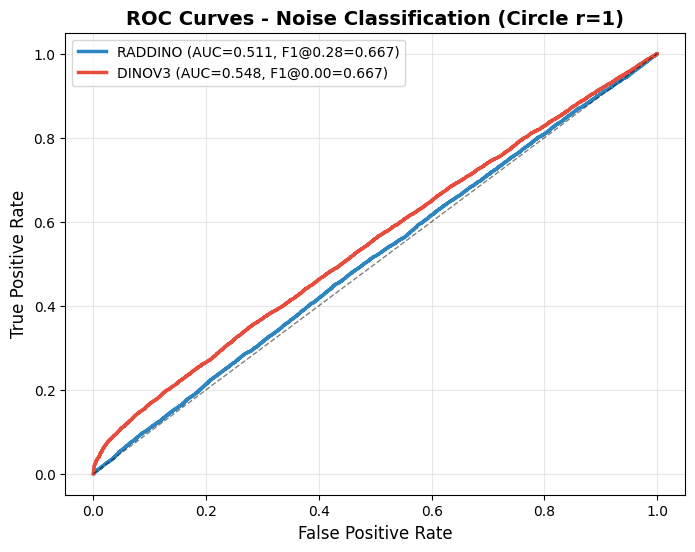


RESULTS SUMMARY
Pattern Type: Circle
Radius:       1
RadDiNo -> AUC: 0.5112 | F1@0.285: 0.6667
DINOv3  -> AUC: 0.5479 | F1@0.005: 0.6667
AUC Δ: 0.0367 | F1 Δ: 0.0000


In [4]:
# Example usage for both patterns:
if __name__ == "__main__":
    analyzer = LinearProbingAnalyzer()

    results_circles = analyzer.run_analysis(
        '/home/rmuthy2/Circle/EmbeddingsOut/raddino-train-r1.parquet',
        '/home/rmuthy2/Circle/EmbeddingsOut/raddino-test-r1.parquet',
        '/home/rmuthy2/Circle/EmbeddingsOut/dinov3-train-r1.parquet', 
        '/home/rmuthy2/Circle/EmbeddingsOut/dinov3-test-r1.parquet',
         radius=1
    )